# Pistachio simulation

<!-- Index of contents -->
* [Define the problem](#Define-the-problem)
* [Simulation agents](#Simulation-agents)
* [Stress types](#Stress-types)
  * [Chill hours stress](#Chill-hours-stress)
  * [Heat units stress](#Heat-units-stress)
  * [Temperature stress](#Temperature-stress)
  * [Hydric stress](#Hydric-stress)
* [Simulation parameters](#Simulation-parameters)

## Define the problem

......

## Simulation agents

In [3164]:
from pydantic import BaseModel, Field, field_validator, model_validator
from typing import List, Literal, Optional
from datetime import date
import numpy as np
from typing import Tuple

from enum import Enum

class IntensityLevel(List[float], Enum):
    low = [0.1, 0.3]
    medium = [0.3, 0.6]
    high = [0.6, 0.8]
    very_high = [0.8, 1.0]

### Weather agent

In [3165]:
# Meteorological Class
import datetime
import time


class Meteorological(BaseModel):
    timestamp: date
    t_med: float = Field(..., ge=-30, le=50, description="Current temperature [-30°C to 50°C]")
    t_min: float = Field(..., ge=-30, le=50, description="Minimum temperature [-30°C to 50°C]")
    t_max: float = Field(..., ge=-30, le=50, description="Maximum temperature [-30°C to 50°C]")
    rh_med: float = Field(..., ge=0, le=100, description="Current relative humidity [0-100%]")
    rh_min: float = Field(..., ge=0, le=100, description="Minimum relative humidity [0-100%]")
    rh_max: float = Field(..., ge=0, le=100, description="Maximum relative humidity [0-100%]")
    wind: float = Field(..., ge=0, description="Current wind speed [0-.. m/s]")
    pp: float = Field(..., ge=0, description="Precipitation level [0-.. mm]")

# Weather Class
class Weather(BaseModel):
    # Input variables
    location: str = Field(..., description="Geographic location, e.g., Valladolid")
    init_date: date = Field(..., description="Initial date")
    end_date: date = Field(..., description="End date")
    available_init_date: date = Field(..., description="Available initial date")
    available_end_date: date = Field(..., description="Available end date")
    type: Literal["normal", "extreme"] = Field(..., description="Type of weather [normal, extreme]")
    # Local variables
    meteorological: List[Meteorological] = Field(default=[], description="List of meteorological data")

    def transform_meteorological_data(self):
        match self.type:
            case "extreme":
                # NOTE: This is a dummy example, in a real case
                for meteorological in self.meteorological:
                    meteorological.temperature += np.random.choice([-5, 5])
                    meteorological.relative_humidity += np.random.choice([-10, 10])
                    meteorological.wind += np.random.choice([-10, 10])
                    meteorological.precipitation += np.random.choice([-10, 10])

    @property
    def idema(self):
        # TODO:
        return "2044B"
    
    def generate_random_weather_data(self) -> List[Meteorological]:
        '''Generate random distribution of meteorological data over init_date and end_date'''
        import random
        import copy
        # self.meteorological_by_year = [[year1_data], [year2_data], ...]
        meteorological_by_year = [[]]
        for i, data in enumerate(self.meteorological):
                if self.meteorological[i-1].timestamp.month == 12 and data.timestamp.month == 1:
                    meteorological_by_year.append([]) # New year
                meteorological_by_year[-1].append(data)
        # Generate random data
        years = self.end_date.year - self.init_date.year + 1 # Number of years to generate
        new_meteorological = random.choices(meteorological_by_year, k=years)
        # Change every timestamp to the new year
        updated_meteorological = []
        for i in range(years):
            selected_year_data = new_meteorological[i]
            copied_year_data = copy.deepcopy(selected_year_data) # This is to avoid reference problems
            new_year = self.init_date.year + i
            for data in copied_year_data:
                try:
                    data.timestamp = data.timestamp.replace(year=new_year)
                except ValueError:
                        data.timestamp = data.timestamp.replace(year=new_year, day=28)

            updated_meteorological.extend(copied_year_data)
        # Sort list
        updated_meteorological.sort(key=lambda x: x.timestamp)
        self.meteorological = updated_meteorological
        return self.meteorological

    def get_weather_data(self):
        import dotenv
        import os
        import requests_cache

        def safe_float(value, default=0.0):
            try:
                return float(value.replace(",", "."))
            except ValueError:
                return default

        dotenv.load_dotenv()
        weather_url = os.getenv("AGROSLAB_API_URL")
        AUTH_TOKEN = os.getenv("AGROSLAB_AUTH_TOKEN")

        headers = {
            'Authorization': AUTH_TOKEN,
        }
        # Loop data every 4 months because the API has a limit of 6 months
        init_date = self.available_init_date
        end_date = self.available_end_date
        while init_date < end_date:
            end_date_query = init_date + datetime.timedelta(days=4 * 30)
            if end_date_query > end_date:
                end_date_query = end_date
            body = {
                "operation": "aemetclimatologiadiaria",
                "initdate": init_date.strftime("%d-%m-%Y"),
                "enddate": end_date_query.strftime("%d-%m-%Y"),
                "idema": self.idema
            }
            if not os.path.exists(f"cache/cache_{init_date.strftime('%Y%m%d')}_{end_date_query.strftime('%Y%m%d')}.sqlite"):
                time.sleep(2)
            session = requests_cache.CachedSession(f"cache/cache_{init_date.strftime('%Y%m%d')}_{end_date_query.strftime('%Y%m%d')}", allowable_methods=('GET', 'POST'))
            data = session.post(weather_url, json=body, headers=headers)
            if data.status_code != 200:
                raise ValueError(data.json())
            historical_data_raw = data.json()
            # Process
            # tmed, velmedia, tmin, tmax, prec, date, hrMedia, hrMax, hrMin
            historical_data = []
            for data in historical_data_raw:
                meteorological = Meteorological(
                    timestamp=date.fromisoformat(data["fecha"]),
                    t_med=safe_float(data.get("tmed", "0")),
                    t_min=safe_float(data.get("tmin", "0")),
                    t_max=safe_float(data.get("tmax", "0")),
                    rh_med=safe_float(data.get("hrMedia", "40")),
                    rh_min=safe_float(data.get("hrMin", "0")),
                    rh_max=safe_float(data.get("hrMax", "0")),
                    wind=safe_float(data.get("velmedia", "0")),
                    pp=safe_float(data.get("prec", "0"))
                )
                historical_data.append(meteorological)
            # value
            self.meteorological.extend(historical_data) 
            init_date = init_date + datetime.timedelta(days=4 * 30 + 1)
        return self.meteorological

### Disease agents

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

| Disease          | Temperature       | Humidity     | Severity   | Treatment difficulty | Period               |
|------------------|-------------------|--------------|------------|-----------------------|----------------------|
| Verticillium     | $20 - 30^{\circ}C$ | Better high  | Very high  | Very high            | June - September     |
| Botryosphaeria   | $27 - 33^{\circ}C$ | Better high  | High       | Medium               | June - September     |
| Alternaria       | $27 - 35^{\circ}C$ | Better high  | Medium     | Medium               | mid July - September |
| Septoria         | $18 - 26^{\circ}C$ | Better high  | High       | Medium               | May - September      |
| Aflatoxins       | $27 - 40^{\circ}C$ | Better high  | Very High  | High                 | Mid August - Harvest |


In [3166]:
from enum import Enum

class DiseaseType(str, Enum):
    Verticillium = "Verticillium"
    Botryosphaeria = "Botryosphaeria"
    Alternaria = "Alternaria"
    Septoria = "Septoria"
    Aflatoxin = "Aflatoxin"

class Disease(BaseModel):
    type: DiseaseType = Field(..., description="Type of disease, e.g., Verticillium, Alternaria")
    RH_disease_min: float = Field(default=65, ge=0, le=100, description="Minimum relative humidity for disease")
    T_disease_min: float = Field(..., ge=0, le=50, description="Minimum temperature for disease")
    T_disease_max: float = Field(..., ge=0, le=50, description="Maximum temperature for disease")
    severity: float = Field(..., ge=0, le=1.0, description="Severity of the disease [low=0.0, high=1.0]")
    treatment_difficulty: float = Field(..., ge=0, le=1.0, description="Difficulty to treat [low=0.0, high=1.0]")
    period_init: int = Field(..., ge=0, le=365, description="Month of the year when the disease can appear")
    period_end: int = Field(..., ge=0, le=365, description="Month of the year when the disease disappears")

    # Allow arbitrary types (ndarray in this case)
    class Config:
        arbitrary_types_allowed = True

    @field_validator('period_end')
    def check_period(cls, period_end, values):
        if period_end < values['period_init']:
            raise ValueError('period_end must be greater than period_init')
        return period_end
        

# # Verticillium Class
# class Verticillium(Disease):
#     type: DiseaseType = DiseaseType.Verticillium
#     T_disease_min: float = 20
#     T_disease_max: float = 30
#     severity: float = IntensityLevel.very_high
#     treatment_difficulty: float = IntensityLevel.very_high
#     period_init: int = 6 # June
#     period_end: int = 9 # September

# # Botryosphaeria Class
# class Botryosphaeria(Disease):
#     type: DiseaseType = DiseaseType.Botryosphaeria
#     T_disease_min: float = 27
#     T_disease_max: float = 33
#     severity: float = IntensityLevel.high
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 6 # June
#     period_end: int = 9 # September

# # Alternaria Class
# class Alternaria(Disease):
#     type: DiseaseType = DiseaseType.Alternaria
#     T_disease_min: float = 27
#     T_disease_max: float = 35
#     severity: float = IntensityLevel.medium
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 7 # July
#     period_end: int = 9 # September

# # Septoria Class
# class Septoria(Disease):
#     type: DiseaseType = DiseaseType.Septoria
#     T_disease_min: float = 18
#     T_disease_max: float = 26
#     severity: float = IntensityLevel.high
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 5 # May
#     period_end: int = 9 # September

# # Aflatoxin Class
# class Aflatoxin(Disease):
#     type: DiseaseType = DiseaseType.Aflatoxin
#     T_disease_min: float = 25
#     T_disease_max: float = 35
#     severity: float = IntensityLevel.very_high
#     treatment_difficulty: float = IntensityLevel.high
#     period_init: int = 8 # August
#     period_end: int = 10 # October

### Pest agents

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

| Pest               | Temperature       | Humidity     | Severity | Treatment difficulty | Period             |
|--------------------|-------------------|--------------|----------|-----------------------|--------------------|
| Green stink bug    | $20 - 35^{\circ}C$ | Better high  | Medium   | High                 | August - October   |
| Pistachio psylla   | $20 - 35^{\circ}C$ | Better high  | High     | High                 | April - October    |
| Leaf beetle        | $20 - 35^{\circ}C$ | Better high  | Low      | Medium               | May                |

In [3167]:
from enum import Enum

class PestType(str, Enum):
    green_stink_bug = "Green stink bug"
    pistachio_psylla = "Pistachio psylla"
    leaf_beetle = "Leaf beetle"

class Pest(BaseModel):
    type: PestType = Field(..., description="Type of pest, e.g., Green stink bug, Leaf beetle")
    RH_pest_min: float = Field(default=65, ge=0, le=100, description="Minimum relative humidity for pest activity")
    T_pest_min: float = Field(..., ge=0, le=50, description="Minimum temperature for pest activity")
    T_pest_max: float = Field(..., ge=0, le=50, description="Maximum temperature for pest activity")
    severity: float = Field(..., ge=0, le=1.0, description="Severity of pest [low=0.0, high=1.0]")
    treatment_difficulty: float = Field(..., ge=0, le=1.0, description="Difficulty to treat [low=0.0, high=1.0]")
    period_init: int = Field(..., ge=0, le=365, description="Month of the year when the pest can appear")
    period_end: int = Field(..., ge=0, le=365, description="Month of the year when the pest disappears")

    @field_validator('period_end')
    def check_period(cls, period_end, values):
        print(period_end)
        if 'period_init' in values and period_end < values['period_init']:
            raise ValueError("period_end must be after period_init")
        return period_end
    
# # Green stink bug Class
# class Green_stink_bug(Pest):
#     type: PestType = PestType.green_stink_bug
#     T_pest_min: float = 20
#     T_pest_max: float = 35
#     severity: float = IntensityLevel.medium
#     treatment_difficulty: float = IntensityLevel.high
#     period_init: int = 8 # June
#     period_end: int = 10 # October

# # Pistachio psylla Class
# class Pistachio_psylla(Pest):
#     type: PestType = PestType.pistachio_psylla
#     T_pest_min: float = 20
#     T_pest_max: float = 35
#     severity: float = IntensityLevel.high
#     treatment_difficulty: float = IntensityLevel.high
#     period_init: int = 4 # April
#     period_end: int = 10 # October

# # Leaf beetle Class
# class Leaf_beetle(Pest):
#     type: PestType = PestType.leaf_beetle
#     T_pest_min: float = 20
#     T_pest_max: float = 35
#     severity: float = IntensityLevel.low
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 5 # May
#     period_end: int = 5 # May

### Farm agent

In [3168]:
class Farm(BaseModel):
    location: str = Field(..., description="Geographic location, e.g., Valladolid")
    irrigation: Literal["rainfed", "irrigated"] = Field(..., description="Type of irrigation [drip, sprinkler]")

class Soil(BaseModel):
    drainage: float = Field(..., ge=0.0, le=1.0, description="Drainage quality [low=0.0, high=1.0]")

### Crop agent

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

#### Rootstock

| **Characteristic**                 | **Rootstocks (in order of preference)**                                                                                  |
|------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| Cold Resistance                    | *P. Cornicabra (or P. Terebinthus)*, *P. Atlantica*                                                                       |
| Resistance to Verticillium         | *P. Integerrima (PGI)*, UCB-1                                                                                            |
| Salinity Resistance                | *P. Atlantica*, *P. Cornicabra*                                                                                          |
| Good Productivity in Poor Soils    | *P. Cornicabra*, *P. Vera*                                                                                               |
| High Yield                         | UCB-1, *P. Integerrima*, *P. Atlantica*, *P. Cornicabra*                                                                 |
| High Vigor (Trunk Diameter)        | *P. Atlantica*, *P. Cornicabra*, *P. Integerrima*, *P. Vera*                                                             |
| Recommended for Dryland Farming    | *P. Cornicabra*                                                                                                          |
| Recommended for Irrigated Farming  | *P. Atlantica*, UCB-1                                                                                                    |


In [3169]:
from enum import Enum
from typing import Union

class RootstockType(str, Enum):
    P_Cornicabra = "P. Cornicabra"
    P_Atlantica = "P. Atlantica"
    UCB_1 = "UCB-1"
    P_Vera = "P. Vera"
    P_Integerrima = "P. Integerrima"

# class Rootstock_P_Cornicabra(BaseModel):
#     type: RootstockType = RootstockType.P_Cornicabra
#     cold_resistance: float = Field(0.15, ge=0, le=1.0, description="Cold resistance level [low=0.0, high=1.0]")

# class Rootstock_P_Atlantica(BaseModel):
#     type: RootstockType = RootstockType.P_Atlantica
#     vigour_increase: float = Field(0.15, ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")
#     cold_resistance: float = Field(0.15, ge=0, le=1.0, description="Cold resistance level [low=0.0, high=1.0]")

# class Rootstock_UCB_1(BaseModel):
#     type: RootstockType = RootstockType.UCB_1
#     resistance_to_verticillium: float = Field(0.4, ge=0, le=1.0, description="Resistance to Verticillium level [low=0.0, high=1.0]")

# class Rootstock_P_Vera(BaseModel):
#     type: RootstockType = RootstockType.P_Vera
#     vigour_increase: float = Field(0.15, ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")

# class Rootstock_P_Integerrima(BaseModel):
#     type: RootstockType = RootstockType.P_Integerrima
#     vigour_increase: float = Field(0.15, ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")
#     resistance_to_verticillium: float = Field(0.3, ge=0, le=1.0, description="Resistance to Verticillium level [low=0.0, high=1.0]")


# Variety Class
class Variety(BaseModel):
    HU_optimal: float = Field(..., ge=0, le=5000, description="Optimal heat units for growth")
    T_base_HU: float = Field(..., ge=0, le=50, description="Base temperature for heat units")
    CH_optimal: float = Field(..., ge=0, le=5000, description="Optimal chill hours")
    T_base_CH: float = Field(..., ge=0, le=50, description="Base temperature for chill hours")
    T_min: float = Field(..., ge=-50, le=50, description="Min temperature that variety holds")
    T_max: float = Field(..., ge=-50, le=50, description="Max temperature that variety holds")
    alternate_bearing: float = Field(..., ge=0, le=1.0, description="Level of alternate bearing [low=0.0, high=1.0]")
    vigour: float = Field(..., ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")
    RH_min_pollination: float = Field(..., ge=0, le=100, description="Minimum relative humidity for pollination")
    RH_max_pollination: float = Field(..., ge=0, le=100, description="Maximum relative humidity for pollination")
    PP_min_year: float = Field(400, ge=0, description="Minimum precipitation per year")
    PP_optimal_year: float = Field(600, ge=0, description="Optimal precipitation per year")
    PP_max_may: float = Field(45, ge=0, description="Maximum precipitation in May")
    PP_max_april: float = Field(50, ge=0, description="Maximum precipitation in April")
    pp_max_sept: float = Field(30, ge=0, description="Maximum precipitation in September")
    #diseases: List[str] = Field(default_factory=list, description="List of diseases affecting the variety")
    #pests: List[str] = Field([*PestType] , description="List of pests affecting the variety")
    rootstock: RootstockType = Field(RootstockType.P_Vera, description="Type of rootstock")
    y_base_rainfed: float = Field(8, ge=0, description="Base yield for rainfed conditions")
    y_base_irrigated: float = Field(15, ge=0, description="Base yield for irrigated conditions")
    max_hours_under_extreme_temperatures: float = Field(0, ge=0, description="Maximum hours under extreme temperatures")
    CH: int = 0
    HU: float = 0

    def calculate_chill_hours(self, t_min_daily:List[float], t_max_daily:List[float]):
        # CROSSA-REYNAUD: 24 * (self.T_base_CH - T_min_daily)/(T_max_daily - T_min_daily)
        self.CH = sum([24 * (self.T_base_CH - t_min_daily) / (t_max_daily - t_min_daily) if t_max_daily != t_min_daily else 0 for t_min_daily, t_max_daily in zip(t_min_daily, t_max_daily)])
        return self.CH


    def calculate_heat_units(self, t_max_monthly:float, t_min_monthly:float):
        # (L.Ferguson, 2015):
        self.HU = ((t_max_monthly + t_min_monthly) / 2) * 213
        return self.HU


# Crop Class
class Crop(BaseModel):
    age: int = Field(10, ge=10, le=100, description="Initial age of the crop [10-100 years]")
    variety: Variety

## Stress types

### Base stress

In biological systems, these processes are usually non-linear \cite{natalia2012}. For instance, when a disease spreads, it begins gradually and takes time to build up. However, as time passes, it spreads more rapidly and through more areas, making it an almost exponential process. Based on this foundation, we will create the following functions, each with the following common elements:

<ul>
<li>
    <strong>Trigger:</strong> <code>&phi;_{trigger}</code> is a function that is 1 when optimal conditions for the stress are accomplished and 0 when not.
</li>
    <li>
        <strong>Evolution function:</strong> It describes how the base stress evolves, due to direct causes described in table <a href="#tab:stress_causes">Table 1</a>. This ranges between 0 and 1 and depends on the relevant parameter. For example, in the case of cold-hour stress, it depends on the number of cold hours. Inside, there is a growth constant (<code>&alpha;_{stress}</code>): This regulates the speed at which stress develops. The range is from -10 to 10. -10 means exponential, 0 means linear and 10 means logarithmic (<code>"growth_rate"</code> in table <a href="#tab:initial-params-desc">Table 2</a>).
    </li>
    <li>
        <strong>Existing stress:</strong> Previous stress in the current year.
    </li>
    <li>
        <strong>Random component:</strong> This corresponds to a statistical distribution to generate randomness (<code>"random_component"</code> in table <a href="#tab:initial-params-desc">Table 2</a>).
    </li>
    <li>
        <strong>Other stressors that accentuate this stress:</strong> Certain types of stress, when they reach a certain level, can trigger or exacerbate other types of stress. For example, poorly pruned branches can cause wounds (mechanical stress), which in turn make the plant more susceptible to pests (pest stress). <code>&phi;_{i}</code> is the trigger function of the stressor and <code>&lambda;_{i}</code> is the importance given to that stressor.
    </li>
</ul>


$$
\footnotesize
S = \phi_{trigger} \cdot ( S_0 + 
\frac{1 - e^{-\alpha_{s} |r_{s}|}}{1 - e^{-\alpha_{s}}} + 
\sum_{i=1}^{n_{s}} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} + \epsilon_{s})
$$

$\footnotesize \alpha_{s} \in [-10, 10]$ and $r_{s} \in [0, 1]$

$\footnotesize \lambda_{osi} \in [0, 0.3]$, $\phi_{osi} = (0,1)$ and $\sum_{i=1}^{n_{stress}} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} $\leq 1$

$
\footnotesize
\phi_{i} = \begin{cases}
    1 & S_i > S_{threshold\_i} \\
    0 & S_i \le S_{threshold\_i}
\end{cases}
$

In [3170]:
class StressType(str, Enum):
    chill_hours = "chill hours stress"
    heat_units = "heat units stress"
    temperature = "temperature stress"
    hydric = "hydric stress"
    nutritional = "nutritional stress"
    mechanical = "mechanical stress"

    

class Stress(BaseModel):
    name: str = Field("", description="Name of the stress")
    stress: float = 0.0
    weight: float = Field(1, ge=0, le=1.0, description="Stress weight [0.0-1.0]")
    ## Exponential function params
    growth_rate: float = Field(..., ge=-10, le=10, description="Growth rate [-10 to 10]")
    ## Other stressors params
    other_stressors_weights: List[float] = Field([], description="Weights of stressors [0.0-1.0]")
    other_stressors_triggers: List[float] = Field([], description="Initial causal stress weights [0.0-1.0]")
    other_stressors: List[float] = Field([], description="Other stressors [0.0-1.0]")
    ## Random component
    random_component: float = Field(..., description="Random component")

    @model_validator(mode="after")
    def check_stress_weights(self):
        if len(self.other_stressors_weights) != len(self.other_stressors_triggers):
            raise ValueError("Weights and triggers must have the same length")
        if len(self.other_stressors_weights) != len(self.other_stressors):
            raise ValueError("Weights and stressors must have the same length")
        return self
    
    @property
    def _trigger(self):
        print("Implement this method in corresponding stress class...")
        raise NotImplementedError

    @property
    def _magnitude_of_stress(self):
        print("Implement this method in corresponding stress class...")
        raise NotImplementedError

    @property
    def _evolution_function(self):
        magnitude = self._magnitude_of_stress
        # print(f"magnitude: {magnitude}")
        return (1 - np.exp(-self.growth_rate * np.abs(magnitude))) / (1 - np.exp(-self.growth_rate))

    @property
    def _other_stressors(self):
        trigger_function = [1 if stressor > causal_stress else 0 for stressor, causal_stress in zip(self.other_stressors, self.other_stressors_triggers)]
        return np.sum(np.multiply(self.other_stressors_weights, trigger_function))

    def calculate_stress(self):
        # print(f"--------- {self.name}...")
        # print(f"trigger: {self._trigger} - growth_rate: {self.growth_rate} evolution: {self._evolution_function} - other: {self._other_stressors} - random: {self.random_component}")
        if self._trigger:
            self.stress = np.clip(self._evolution_function \
                + self._other_stressors \
                + self.random_component, 0, 1)
        # print(f"stress: {self.stress}")
        return self.stress


### Chill hours stress

$$
\footnotesize
    S_{CH}(CH) = \begin{cases}
    \frac{1 - e^{-\alpha_{cold} |r_{cold}|}}{1 - e^{-\alpha_{cold}}} + \epsilon & CH < CH_{optimal}\\
    0 & CH \ge CH_{optimal}
\end{cases}
$$

$\footnotesize CH_{optimal} =$ are the optimal chill hours for the corresponding pistachio variety.

$\footnotesize r_{cold} = 0 \ge \frac{CH_{optimal} - CH}{CH_{optimal}} > 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [3171]:
class ChillHoursStress(Stress):
    name: str = StressType.chill_hours.value
    # Stress input params
    CH: float = Field(..., ge=0, le=5000, description="Chill hours")
    # Stress specific local params
    CH_optimal: float = Field(..., ge=0, le=5000, description="Optimal chill hours")

    @property
    def _trigger(self):
        return self.CH < self.CH_optimal

    @property
    def _magnitude_of_stress(self):
        return min((self.CH_optimal - self.CH) / self.CH_optimal, 1)

### Heat units stress

$$
\footnotesize
    S_{HU}(HU) = \begin{cases}
    \frac{1 - e^{-\alpha_{heat} |r_{heat}|}}{1 - e^{-\alpha_{heat}}} + \epsilon & CH < CH_{optimal}\\
    0 & HU \ge HU_{optimal}
\end{cases}
$$

$\footnotesize HU_{optimal} =$ are the optimal heat units for the corresponding pistachio variety.

$\footnotesize r_{heat} = 0 \ge \frac{HU_{optimal} - HU}{HU_{optimal}} > 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [3172]:
class HeatUnitsStress(Stress):
    name: str = StressType.heat_units.value
    # Stress input params
    HU: float = Field(..., ge=0, description="Heat units")
    # Stress specific local params
    HU_optimal: float = Field(..., ge=0, description="Optimal heat units")

    @property
    def _trigger(self):
        return self.HU < self.HU_optimal

    @property
    def _magnitude_of_stress(self):
        return min((self.HU_optimal - self.HU) / self.HU_optimal, 1)

### Temperature stress

$$
\footnotesize
S_{temp}(H_{T\_ext}) = \begin{cases}
    S_{temp\_0} + \frac{1 - e^{-\alpha_{temp} |r_{temp}|}}{1 - e^{-\alpha_{temp}}} + \epsilon & H_{T\_ext} > 0\\
    0 & H_{T\_ext} = 0
\end{cases}
$$

$
\footnotesize
H_{T\_ext} = \text{hours}(T \ge T_{max} \vee T_{min} \ge T)
$

$
\footnotesize
r = 0 \ge \frac{H_{T\_ext}}{H_{T\_ext\_max}} \ge 1
$

$
\footnotesize
H_{T\_ext\_max} =$ hours of extreme temperatures between $T_{min}$ and $T_{max}
$

$
\footnotesize
\epsilon \sim N(\mu, \sigma)
$

In [3173]:
class TemperatureStress(Stress):
    name: str = StressType.temperature.value
    # Stress input params
    hours_under_extreme_temperature: int = Field(..., ge=0, description="Hours under extreme temperature")
    # Stress specific local params
    max_hours_under_extreme_temperature: int = Field(730, ge=0, description="Max hours under extreme temperature")
    
    @property
    def _trigger(self):
        return self.hours_under_extreme_temperature > 0

    @property
    def _magnitude_of_stress(self):
        return min(self.hours_under_extreme_temperature / self.max_hours_under_extreme_temperature, 1)

### Hydric stress

$$
\footnotesize
S_{hydric}(PP) = \begin{cases}
    S_{hydric\_0} + \frac{1 - e^{-\alpha_{hydric} |r_{hydric}|}}{1 - e^{-\alpha_{hydric}}} + \epsilon & PP < PP_{min} \vee PP > PP_{max}\\
    S_{hydric\_0} & PP_{min} \ge PP \ge PP_{max}
\end{cases}
$$

$
\footnotesize
r_{hydric} = 0 \ge \frac{PP_{optimal} - PP}{PP_{optimal} - PP_{min}} \ge 1
$

$
\footnotesize
\epsilon \sim N(\mu, \sigma)
$

In [3174]:
class HydricStress(Stress):
    name: str = StressType.hydric.value
    # Stress input params
    PP: float = Field(..., ge=0, description="Precipitation level")
    # Stress specific local params
    PP_min: float = Field(..., ge=0, description="Minimum precipitation level")
    PP_max: float = Field(..., ge=0, description="Maximum precipitation level")

    @property
    def _trigger(self):
        return self.PP < self.PP_min or self.PP > self.PP_max

    @property
    def _magnitude_of_stress(self):
        if self.PP < self.PP_min:
            return (self.PP_min - self.PP) / self.PP_min
        if self.PP > self.PP_max:
            return (self.PP - self.PP_max) / self.PP_max
        return 0

### Mechanical stress

$$
\footnotesize
S_{mechanical} = \begin{cases}
 S_{mechanical\_0} + 1 - M & \text{farming activity}\\
 S_{mechanical\_0} & \text{no farming activity}
\end{cases}
$$

$
\footnotesize
\text{farming\_activity} \sim N(\mu, \sigma)$ represents the success of farming activities such as pruning, harvesting, etc, without damaging the plant.

In [3175]:
class MechanicalStress(Stress):
    name: str = StressType.mechanical.value
    # Stress specific local params
    farming_activity: float = Field(..., description="Farming activity")

    @property
    def _trigger(self):
        return True

    @property
    def _evolution_function(self):
        return self.farming_activity

### Nutritional stress

$$
\footnotesize
S_{nutritional} = \begin{cases}
 S_{nutritional\_0} + 1 - N + \sum_{i=1}^{n\_stress} \lambda_{i} \cdot \phi_{i} \cdot S_{i} & \text{fertilisation}\\
 S_{nutritional\_0} & \text{no fertilisation}
\end{cases}
$$

$
\footnotesize
N \sim N(\mu, \sigma)$ represents the success of fertilisation (fert) activity between 0 and 1.

$\footnotesize n\_estres =$ \{hydric\}

$
\footnotesize
\epsilon \sim N(\mu, \sigma)$

In [3176]:
class NutritionalStress(Stress):
    name: str = StressType.nutritional.value
    # Stress specific local params
    fertilisation: float = Field(..., description="Fertilisation activity")

    @property
    def _trigger(self):
        return True

    @property
    def _evolution_function(self):
        return self.fertilisation

### Pest and disease stress

$$
\footnotesize
S_{pest}(H_{RH\_pest}, H_{T\_pest}) = \begin{cases}
    S_{pest\_0} + \frac{1 - e^{-\alpha_{pest} |r_{pest}|}}{1 - e^{-\alpha_{pest}}} + \sum_{i=1}^{n_{stress}} \lambda_{i} \cdot \phi_{i} \cdot S_{i} + \epsilon & H_{RH\_pest} > 0 \wedge H_{T\_pest} > 0 \\
    S_{pest\_0} & H_{RH\_pest} = 0 \vee H_{T\_pest} = 0
\end{cases}\\
$$

$\footnotesize
H_{RH\_pest} = \text{hours}(RH \ge RH\_pest\_min)$ \& $H_{T\_pest} = \text{hours}(T_\_pest\_min \le T \le T_\_pest\_max)$ These are the hours of exposition to favourable relative humidity and temperature of pest.

$\footnotesize n_{stress} =$ \{mechanical, heat\_units\}

$\footnotesize \alpha_{pest}$ is the severity of the pest, that represents the growth speed of the pest.

$\footnotesize r_{pest} = 0 \ge avg(\frac{H_{RH\_pest}}{H_{RH\_pest\_max}}, \frac{H_{T\_pest}}{H_{T\_pest\_max}}) \ge 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [3177]:
class PestDiseaseStress(Stress):
    # Stress input params
    hours_under_optimal_temperature: int = Field(0, ge=0, description="Hours under optimal temperature in a period")
    hours_under_optimal_rh: int = Field(0, ge=0, description="Hours under optimal relative humidity in a period")
    # Stress specific local params
    max_hours_under_optimal_t: int = Field(..., ge=0, description="Max hours under optimal temperature")
    max_hours_under_optimal_rh: int = Field(..., ge=0, description="Max hours under optimal relative humidity")

    @property
    def _trigger(self):
        return self.hours_under_optimal_temperature > 0 and self.hours_under_optimal_rh > 0

    @property
    def _magnitude_of_stress(self):
        return min(self.hours_under_optimal_temperature / self.max_hours_under_optimal_t, 1) \
            + min(self.hours_under_optimal_rh / self.max_hours_under_optimal_rh, 1)

### Total stress

Equation shows the accumulated total stress that is calculated as the weighted average of each corresponding stress and the residual stress, where each $\lambda_{i}$ represents the weighted importance assigned to each one, $n_{stress} \in$ {chill hours, temperature, heat units, water, mechanical, nutritional, pest, disease}, $\lambda_{prev}$ is the weighted importance assigned to the previous residual stress and $S_{prev}$ is the previous residual stress of last productive years. $S_{total}$ must always be between 0 and 1.

$$
\footnotesize
S_{total} = min(\lambda_{prev} \cdot S_{prev} + \sum_{i=1}^{n\_stress} \lambda_{i} \cdot S_{i}, 1)
$$

In [3178]:
class TotalStress(BaseModel):
    total_stress: float = 0
    # Stress specific local params
    stressors: List[Tuple[float, float]] = Field(..., description="List of tuples where each tuple contains (stress_weight, stress_level)")
    previous_stress_weight: float = Field(..., ge=0, le=1.0, description="Previous stress weight [0.0-1.0]")
    previous_stress: float = Field(..., ge=0, le=1.0, description="Previous stress level [0.0-1.0]")

    def calculate(self):
        effective_previous_stress = self.previous_stress_weight * self.previous_stress
        self.total_stress = min(effective_previous_stress + sum([stress_weight * stress for stress_weight, stress in self.stressors]), 1)
        return self.total_stress

## Stress-based estimated yield equation

The following equation calculates the approximated yield per tree in a productive year, where γpollination
is the degree of female tree pollination, γbearing is the alternate bearing suffered -depends on
“on”-“off” cycle-, γage is the increase of yield that depends on the tree’s age, Stotal is the total
accumulated stress, Ybase is a baseline yield determined by extracted knowledge and ϵ is a
probabilistic distribution that adds randomness. Ybase depends on whether the tree is grown
under rainfed or irrigated conditions


$$
\footnotesize
Y = \begin{cases}
    \gamma_{pollination} \cdot ((1 - S_{total}) \cdot Y_{base} + \gamma_{age}) + \epsilon_{y} & \text{``on'' year} \\
    \gamma_{pollination} \cdot (\gamma_{bearing} \cdot (1 - S_{total}) \cdot Y_{previous}) + \epsilon_{y} & \text{``off'' year}
\end{cases}
$$

$\footnotesize \gamma_{age}$ represents that every two years production raises 1 kilograms in case of rainfed and 1.5 kilograms in case of irrigated.

$$
\footnotesize
\gamma_{age} = \begin{cases}
    1 \cdot (\text{age \%}\ 2 - 5)\ \text{kilograms} & \ge 10\ \text{years old} \wedge \text{rainfed} \\
    1.5 \cdot (\text{age \%}\ 2 - 5)\ \text{kilograms} & \ge 10\ \text{years old} \wedge \text{irrigated}
\end{cases}
$$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

$\footnotesize \gamma_{bearing}$ represents the intensity of the alternate bearing and depends on the last year production and the pistachio variety. It should be between 50\% and 80\% less than the last year production, depending on the stress levels.

$$
\footnotesize
\gamma_{bearing} = (1 - AB - 0.2) \le \epsilon_{bearing} - \lambda_{bearing\_total} \cdot S_{total} \le (1 - AB)
$$

$\footnotesize AB$ is alternate bearing.

$\footnotesize \epsilon_{bearing} \sim U(0.3, 0.5)$

$\footnotesize \gamma_{pollination}$ represents the percentage of pollination of male trees to female ones in April. It ranges between 0 and 1.

$$
\footnotesize
\gamma_{pollination} = \begin{cases}
    1 - \frac{1 - e^{-\alpha_{pollination} |r_{pollination}|}}{1 - e^{-\alpha_{pollination}}} - \lambda_{CH} \cdot S_{CH} + \epsilon_{pollination} & RH > 80\% \vee PP > 50 mm\\
    1 & RH < 80\% \wedge PP \le 50 mm
\end{cases}
$$

$
\footnotesize
r_{pollination} = 0 \ge avg(\frac{RH - RH_{min}}{RH_{max} - RH_{min}}, \frac{PP - PP_{min}}{PP_{max} - PP_{min}}) > 1
$

$\footnotesize \epsilon_{pollination} \sim N(\mu, \sigma)$

$\footnotesize Y_{base}$ is the base production of the registered average according to knowledge. We have seen that is around 8 kilograms in rainfed regime and around 15 kilograms in irrigation regime.

$$
\footnotesize
Y_{base} = \begin{cases}
    8\ kilograms & \ge 10\ years\ old \wedge rainfed \\
    15\ kilograms & \ge 10\ years\ old \wedge irrigated
\end{cases}
$$

In [3179]:
from pydantic import BaseModel, Field
from typing import Literal
import numpy as np

class EstimatedYield(BaseModel):
    # Input parameters
    age: int = Field(..., ge=10, description="Age of the tree in years")
    irrigation: Literal["rainfed", "irrigated"] = Field(..., description="Irrigation type (rainfed or irrigated)")
    alternate_bearing: float = Field(..., ge=0.5, le=0.8, description="Intensity of alternate bearing (0.5 to 0.8)")
    epsilon_bearing: float = Field(..., ge=0.3, le=0.5, description="Bearing growth rate parameter")
    total_stress: float = Field(..., ge=0, le=1, description="Total accumulated stress (0 to 1)")
    avg_rh_april: float = Field(..., ge=0, le=100, description="Average relative humidity in April (%)")
    pp_april: float = Field(..., ge=0, description="Precipitation in April (mm)")
    alpha_pollination: float = Field(..., description="Pollination growth rate parameter")
    lambda_ch: float = Field(..., ge=0, le=1, description="Weight of chill hours stress in pollination")
    s_ch: float = Field(..., ge=0, le=1, description="Chill hours stress (0 to 1)")
    random_component: float = Field(..., description="Random component")
    y_base_rainfed: float = Field(8, description="Base yield for rainfed trees")
    y_base_irrigated: float = Field(15, description="Base yield for irrigated trees")
    y_increase_irrigated: float = Field(1.5, description="Yield increase for irrigated trees")
    y_increase_rainfed: float = Field(1.0, description="Yield increase for rainfed trees")
    max_pollination_rh: float = Field(85, description="Maximum relative humidity for pollination")
    min_pollination_rh: float = Field(60, description="Minimum relative humidity for pollination")
    max_pollination_pp: float = Field(50, description="Maximum precipitation for pollination")
    min_pollination_pp: float = Field(10, description="Minimum precipitation for pollination")
    is_on_year: bool = False
    yield_previous: float = 0.0

    # Allow arbitrary types (ndarray in this case)
    class Config:
        arbitrary_types_allowed = True

    # Computed properties
    @property
    def _gamma_age(self) -> float:
        """Compute gamma_age based on the age and irrigation type. Every 2 years,
        accumulated_yield increases by 1.5 for irrigated and 1.0 for rainfed"""
        if self.age >= 10:
            return self.y_increase_irrigated * (self.age // 2 - 5) if self.irrigation == "irrigated" else self.y_increase_rainfed * (self.age // 2 - 5)
        return 0.0

    @property
    def _gamma_bearing(self) -> float:
        """Compute gamma_bearing based on alternate bearing and stress levels."""
        alternate_bearing = 1 - self.alternate_bearing
        # print(np.clip(self.epsilon_bearing - 0.5 * self.total_stress, alternate_bearing - 0.2, alternate_bearing))
        return np.clip(self.epsilon_bearing - 0.3 * self.total_stress, alternate_bearing - 0.2, alternate_bearing)

    @property
    def _gamma_pollination(self) -> float:
        # TODO: QUIZAS DERIVAR DE LA CLASE Stress PORQUE LA FORMULA ES LA MISMA
        """Compute gamma_pollination based on humidity, precipitation, and stress."""
        # if self.avg_rh_april > self.max_pollination_rh or self.pp_april > self.max_pollination_pp:
        #     r_pollination = np.mean([(self.avg_rh_april - self.min_pollination_rh) / (self.max_pollination_rh - self.min_pollination_rh), self.pp_april / self.max_pollination_pp])
        #     exponential_term = (
        #         1 - np.exp(-self.alpha_pollination * abs(r_pollination))
        #     ) / (1 - np.exp(-self.alpha_pollination))
        #     return np.clip(1 - exponential_term - self.lambda_ch * self.s_ch + self.random_component, 0, 1)
        return 1.0


    @property
    def _y_base(self) -> float:
        """Compute Y_base based on age and irrigation type."""
        if self.age >= 10:
            return self.y_base_rainfed if self.irrigation == "rainfed" else self.y_base_irrigated
        return 0.0

    def calculate_yield(self) -> float:
        """Calculate the estimated yield per tree."""
        random_component = self.random_component
        self.is_on_year = self.age % 2 == 0
        if self.is_on_year:
            return (
                self._gamma_pollination *
                ((1 - self.total_stress) * self._y_base + self._gamma_age) +
                random_component
            )
        return (
            self._gamma_pollination *
            (self._gamma_bearing * (1 - self.total_stress) * self.yield_previous) +
            random_component
        )

## Simulation parameters

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

In this case, we are going to be using the **Kerman variety** of pistachio, which is the most common variety in Spain. It is usually used with the rootstock **Pistacia atlantica**. The following table shows the initial parameters for the simulation.

Crop

Aquí está la tabla sin la columna "Test value":

### Crop

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| init_age | Initial age of the crop at the start of the simulation (e.g., 0, 1, 10). | - | - |
| $CH\_optimal$ | Optimal chill hours for the Kerman variety, representing the number of hours below a certain temperature needed for flowering (typically between 500 and 1500). | 1000 | --- |
| $HU\_optimal$ | Optimal heat units required for the Kerman variety to develop fully during the growing season (e.g., 2000–4000). | 3500 | --- |
| $T\_min$ | Minimum temperature that the crop can tolerate without damage (e.g., -40 to 0 ºC). | -30 ºC | --- |
| $T\_max$ | Maximum temperature that the crop can tolerate without damage (e.g., 30 to 60 ºC). | 50 ºC | --- |
| $T\_base\_CH$ | Base temperature for calculating chill hours, where temperatures below this contribute to chilling (e.g., 0 to 10 ºC). | < 7 ºC | - |
| $T\_base\_HU$ | Base temperature for calculating heat units, where temperatures above this contribute to development (e.g., > 10 ºC). | > 10 ºC | - |
| alternate_bearing | Represents the alternate bearing tendency of the crop (values typically between 0.6 and 0.8). | [0.6–0.8] | --- |
| vigour | Represents the vigor of the crop (e.g., low, medium, high). | Medium | - |
| RH_min_pollination | Minimum relative humidity required for effective pollination (e.g., 40–60%). | 50% | --- |
| RH_max_pollination | Maximum relative humidity threshold for effective pollination (e.g., 75–90%). | 90% | --- |
| PP_min_year | Minimum yearly precipitation needed for the crop (e.g., 300–500 mm). | 400 mm | --- |
| PP_optimal_year | Optimal yearly precipitation for the crop (e.g., 500–800 mm). | 600 mm | --- |
| PP_max_may | Maximum precipitation allowed in May to avoid damage (e.g., 30–60 mm). | 45 mm | --- |
| PP_max_april | Maximum precipitation allowed in April to avoid damage (e.g., 40–70 mm). | 50 mm | --- |
| PP_max_sept | Maximum precipitation allowed in September to avoid damage (e.g., 20–50 mm). | 30 mm | --- |
| y_base_rainfed | Base yield for a rainfed crop under normal conditions (e.g., 5–10). | 8 | --- |
| y_base_irrigated | Base yield for an irrigated crop under normal conditions (e.g., 10–20). | 15 | --- |
| y_increase_rainfed | Yield increase for rainfed crops per additional improvement factor (e.g., 0.5–2). | 1 | --- |
| y_increase_irrigated | Yield increase for irrigated crops per additional improvement factor (e.g., 1–3). | 1.5 | --- |
| rootstock | Type of rootstock used for the crop (e.g., UCB-1, P. Vera). | - | - |
| max_hours_under_extreme_temperatures $(H_{T\_ext})$ | Maximum allowable hours under extreme temperatures without significant damage (e.g., 600–1000 hours). | - | --- |

---

### **Soil Parameters**

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| drainage | Soil drainage quality (e.g., low, medium, high). | - | --- |

---

### **Farm Parameters**

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| irrigation | Type of irrigation used on the farm (e.g., rainfed, irrigated). | - | --- |

---

### **Weather Parameters**

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| location | Location of the farm (e.g., Valladolid, California). | - | - |
| init_date | Start date for the simulation (e.g., 01/10/2010). | - | - |
| end_date | End date for the simulation (e.g., 01/09/2020). | - | - |
| type | Type of weather scenario (e.g., normal, extreme). | - | - |

---

### **Disease and Pest Agents Parameters**

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| type | Type of disease or pest affecting the crop (e.g., Verticillium, Botryosphaeria). | - | - |
| RH_disease_min | Minimum relative humidity for the disease to thrive (e.g., 60–80%). | Better high | --- |
| severity | Severity level of the disease or pest (e.g., low, medium, high, very high). | Specific of table \ref{} | --- |
| treatment_difficulty | Difficulty level of treating the disease or pest (e.g., low, medium, high). | Specific of table \ref{} | --- |
| T_disease_min | Minimum temperature for the disease to thrive (e.g., 15–30 ºC). | Specific of table \ref{} | --- |
| T_disease_max | Maximum temperature for the disease to thrive (e.g., 25–40 ºC). | Specific of table \ref{} | --- |
| period_init | Start period of disease or pest activity (e.g., April, May). | Specific of table \ref{} | - |
| period_end | End period of disease or pest activity (e.g., September, October). | Specific of table \ref{} | - |
| max_hours_under_optimal_rh | Maximum hours under optimal relative humidity for disease or pest development (e.g., 100–200 hours). | - | --- |
| max_hours_under_optimal_t | Maximum hours under optimal temperature for disease or pest development (e.g., 100–300 hours). | - | --- |

---

### **Stress Parameters**

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| weight $(\lambda_{ti})$ | Weight of the stress type's contribution to total stress (e.g., 0.1–1.0). | - | --- |
| growth_rate $(\alpha_{s})$ | Rate of stress growth based on environmental or crop conditions (e.g., -5 to 5). | - | --- |
| other_stressors_weights $(\lambda_{osi})$ | Weights of interactions between stressors (e.g., 0.0–1.0). | - | --- |
| other_stressors_triggers $\phi_{osi}$ | Thresholds for activating stressor interactions (e.g., 0.0–1.0). | - | --- |
| random_component $(\epsilon_{s})$ | Random noise component added to stress calculations (e.g., -0.25 to 0.25). | - | --- |

---

### **Total Stress Parameters**

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| previous_stress_weight ($\lambda_{prev}$) | Weight of previous stress's influence on current stress (e.g., 0.1–0.5). | - | --- |

---

### **Stress-Based Estimated Yield**

| **Parameter** | **Description** | **Theoretical Value** | **Optimal Value** |
| --- | --- | --- | --- |
| random_component $(\epsilon_{y})$ | Random noise component added to yield estimation (e.g., -0.25 to 0.25). | - | --- |
| alpha_pollination $(\alpha_{pollination})$ | Factor representing pollination efficiency's influence on yield (e.g., -5 to 5). | - | --- |

---


## Simulation

<style scoped>
  code {
    font-size: 16px;
    font-family: Verdana, sans-serif;
    /* No text bg colour */
    background-color: transparent;
  }
</style>

Pseudocode:

```
function simulation (init_date, end_date, input_params):
  for year in range(init_date, end_date):
    weather_agent, crop, farm, soil, diseases, pests <- reset(input_params, year)

    # Anual stress
    stress[ch_stress] <- chill_hours_stress(crop.CH)
    stress[heat_units_stress] <- heat_units_stress(crop.HU)
    stress[temp_stress] <- temperature_stress(weather.meteorologic.t_med)
    stress[mechanical_stress] <- mechanical_stress(farm.fieldwork)
    stress[nutritional_stress] <- nutritional_stress(farm.fertilisation)
    
    # Temporal restricted stress
    for stress in list(diseases, pests):
      weather_in_outbreak_period <- weather_agent.get_weather(stress.period_init, stress.period_end)
      stress[pest_stress_{pest}] <- pest_stress(weather_in_outbreak_period.RH, weather_in_outbreak_period.T)
      stress[disease_stress_{disease}] <- disease_stress(weather_in_outbreak_period.RH, weather_in_outbreak_period.T)
    
    for weather_month in weather_agent.get_weather(init_date, end_date):
      stress[hydric] <- hydric_stress + hydric_stress(weather_month.PP)
        
    total_stress <- prev_stress + weighted_sum(stress[...n])
    y <- estimated_yield(total_stress, ...otger_args)
    
    # Save synthetic data
    save_data(y, total_stress, stress[...n], ...agents)

```

In [3180]:
from math import floor
import os

def get_value(range_, size=50):
    '''Get a random value from a range and if the range has only one value, return it'''
    if isinstance(range_, (list)):
      # if it contains other things than numbers, return a random value
      if not all(isinstance(i, (int, float, str)) for i in range_):
        return range_
      if len(range_) == 0:
        return range_
      if range_[-1] == "beta":
          return np.random.choice(np.random.beta(range_[0], range_[1], size))
      if range_[-1] == "normal":
          return np.random.choice(np.random.normal(range_[0], range_[1]/3, size))
      if len(range_) == 1:
          return range_[0]
      if len(range_) == 2:
          return np.random.choice(np.random.uniform(range_[0], range_[1], size))
      return np.random.choice(range_)
    return range_

def process_parameters(params):
    '''Recursively process the parameters'''
    if isinstance(params, dict):
        return {key: process_parameters(get_value(value)) for key, value in params.items()}
    elif isinstance(params, list):
        return [process_parameters(get_value(value)) for value in params]
    else:
        return get_value(params)

params = {
   "weather": {
      "location": "Valladolid",
      "available_init_date": date(2010, 10, 1),
      "available_end_date": date(2020, 12, 1),
      "init_date": date(1970, 10, 1),
      "end_date": date(2020, 9, 1),
      "type": "normal",
   },
   "farm": {
      "location": "Valladolid",
      "irrigation": "rainfed",
    },
    "soil": {
      "drainage": IntensityLevel.high.value,
    },
    "crop": {
      "age": 10,
      "variety": {
          "alternate_bearing": IntensityLevel.high.value,
          "vigour": IntensityLevel.medium.value,
          "HU_optimal": 3500,
          "T_base_HU": 10,
          "CH_optimal": 1000,
          "T_base_CH": 7,
          "T_min": -30,
          "T_max": 50,
          "RH_min_pollination": [40, 60],
          "RH_max_pollination": [75, 90],
          "PP_min_year": 300,
          "PP_optimal_year": 600,
          "PP_max_may": 50,
          "PP_max_april": 45,
          "pp_max_sept": 30,
          "y_base_rainfed": 8,
          "y_base_irrigated": 15,
          "y_increase_rainfed": 1.0,
          "y_increase_irrigated": 1.5,
          "rootstock": RootstockType.P_Vera.value,
          "max_hours_under_extreme_temperatures": [24*7*4, 24*7*6],
      },
    },
    "stress": {
        "previous_stress_weight": [0.1, 0.5],
        "chill_hours": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "heat_units": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "temperature": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "hydric": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0.5, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "mechanical": {
            "weight": [0.5, 1],
            "farming_activity": [0.5, 2, "beta"],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "nutritional": {
            "weight": [0.5, 1],
            "fertilisation": [0.5, 2, "beta"],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": [
                {
                    "name": StressType.heat_units.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                }
            ]
        },
        "pest": {
           "types": [
              {
                  "weight": [0, 1],
                  "random_component": [0, 0.25, "normal"],
                  "max_hours_under_optimal_t": [24*3, 24*7],
                  "max_hours_under_optimal_rh": [24*3, 24*7],
                  "characteristics": {
                      "type": PestType.green_stink_bug,
                      "RH_pest_min": 65,
                      "T_pest_min": 20,
                      "T_pest_max": 35,
                      "severity": IntensityLevel.medium.value,
                      "treatment_difficulty": IntensityLevel.high.value,
                      "period_init": 8,
                      "period_end": 10
                  }
              },
              {
                  "weight": [0, 1],
                  "random_component": [0, 0.25, "normal"],
                  "max_hours_under_optimal_t": [24*3, 24*7],
                  "max_hours_under_optimal_rh": [24*3, 24*7],
                  "characteristics": {
                      "type": PestType.pistachio_psylla,
                      "RH_pest_min": 65,
                      "T_pest_min": 20,
                      "T_pest_max": 35,
                      "severity": IntensityLevel.high.value,
                      "treatment_difficulty": IntensityLevel.high.value,
                      "period_init": 4,
                      "period_end": 10
                  }
              },
              {
                  "weight": [0, 1],
                  "random_component": [0, 0.25, "normal"],
                  "max_hours_under_optimal_t": [24*3, 24*7],
                  "max_hours_under_optimal_rh": [24*3, 24*7],
                  "characteristics": {
                      "type": PestType.leaf_beetle,
                      "RH_pest_min": 65,
                      "T_pest_min": 20,
                      "T_pest_max": 35,
                      "severity": IntensityLevel.low.value,
                      "treatment_difficulty": IntensityLevel.medium.value,
                      "period_init": 5,
                      "period_end": 5
                  }
              }
          ],
            "other_stressors": [
                {
                    "name": StressType.heat_units.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                {
                    "name": StressType.mechanical.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                }
            ]
        },
        "disease": {
            "types": [
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Verticillium,
                        "RH_disease_min": 65,
                        "T_disease_min": 20,
                        "T_disease_max": 30,
                        "severity": IntensityLevel.very_high.value,
                        "treatment_difficulty": IntensityLevel.very_high.value,
                        "period_init": 6,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Botryosphaeria,
                        "RH_disease_min": 65,
                        "T_disease_min": 27,
                        "T_disease_max": 33,
                        "severity": IntensityLevel.high.value,
                        "treatment_difficulty": IntensityLevel.medium.value,
                        "period_init": 6,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Alternaria,
                        "RH_disease_min": 65,
                        "T_disease_min": 27,
                        "T_disease_max": 35,
                        "severity": IntensityLevel.medium.value,
                        "treatment_difficulty": IntensityLevel.medium.value,
                        "period_init": 7,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Septoria,
                        "RH_disease_min": 65,
                        "T_disease_min": 18,
                        "T_disease_max": 26,
                        "severity": IntensityLevel.high.value,
                        "treatment_difficulty": IntensityLevel.medium.value,
                        "period_init": 5,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Aflatoxin,
                        "RH_disease_min": 65,
                        "T_disease_min": 25,
                        "T_disease_max": 35,
                        "severity": IntensityLevel.very_high.value,
                        "treatment_difficulty": IntensityLevel.high.value,
                        "period_init": 8,
                        "period_end": 10
                    }
                }
            ],
            "other_stressors": [
                {
                    "name": StressType.heat_units.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                # {
                #     "name": StressType.pest.value,
                #     "weight": [0.0, 1.0],
                #     "trigger": [0.0, 1.0]
                # },
                {
                    "name": StressType.mechanical.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                {
                    "name": StressType.nutritional.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                {
                    "name": StressType.hydric.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                }
            ]
        }
    },
    "yield": {
        "random_component": [0, 0.25, "normal"],
        "alpha_pollination": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
        "lambda_ch": [0.0, 1.0],
        "epsilon_bearing": [0.3, 0.5]
    }
}



# Lo que provoca
# irrigation -> 
#   irrigated -> weight_hydric_stress = [0, 0.3]
# treatment_difficulty -> 
#   very_high -> weight_pest_disease_stress = [0.9, 1]
#   high -> weight_pest_disease_stress = [0.6, 0.9]
#   medium -> weight_pest_disease_stress = [0.4, 0.6]
#   low -> weight_pest_disease_stress = [0.2, 0.4]
# drainage ->
#   low -> weight_hydric_stress = [0.6, 1]
#   medium -> weight_hydric_stress = [0.3, 0.6]
#   high -> weight_hydric_stress = [0, 0.3]
# rootstock.P_Vera -> weight_temperature_stress--
# rootstock.P_Vera -> weight_general -
# rootstock.UCB_1 -> weight_verticillium_stress = [0, 0.2]
# rootstock.P_Cornicabra -> weight_nutritional_stress-
# rootstock.P_Cornicabra -> weight_temperature_stress--
# rootstock.P_Cornicabra -> weight_general -
# rootstock.P_Intergerrima -> weight_verticillium_stress = [0, 0.2]
# rootstock.P_Integerrima -> weight_general -
# rootstock.P_Atlantica -> weight_temperature_stress--
# rootstock.P_Atlantica -> weight_general -

def read_real_data(filename="real_data.csv"):
  import pandas as pd
  if os.path.exists(filename):
    return pd.read_csv(filename)
  return None


def simulation(params, filename="results.csv", save_results=True):

  # Get real data
  real_data = read_real_data()

  estimated_yield = 0.0
  total_stress = 0.0
  previous_stress = 0.0
  previous_yield = 0.0
  age = params["crop"]["age"]

  # For every year in the simulation
  init = params["weather"]["init_date"]
  end = params["weather"]["end_date"].replace(year=init.year+1)

  residuals = 0

  # Get the weather data
  weather = Weather(
    location=params["weather"]["location"],
    init_date=params["weather"]["init_date"],
    end_date=params["weather"]["end_date"],
    available_init_date=params["weather"]["available_init_date"],
    available_end_date=params["weather"]["available_end_date"],
    type=params["weather"]["type"]
  )


  weather.transform_meteorological_data()
  weather.get_weather_data()
  weather.generate_random_weather_data()

  while init < params["weather"]["end_date"]:
    # For every nested param, get random values
    params = process_parameters(params)

    year = init.year
    # Take weather of the year
    weather_year = [day for day in weather.meteorological if day.timestamp >= init and day.timestamp < end]
    print(weather_year)
    stress: List[Stress] = []

    # Get the heat units in months 4-10 and chill hours in months 11-2
    t_min_monthly_hu =  np.mean([day.t_min for day in weather_year if 4 <= day.timestamp.month <= 10])
    t_max_monthly_hu =  np.mean([day.t_max for day in weather_year if 4 <= day.timestamp.month <= 10])
    t_min_daily_ch =  [day.t_min for day in weather_year if day.timestamp.month in [11,12,1,2]]
    t_max_daily_ch =  [day.t_max for day in weather_year if day.timestamp.month in [11,12,1,2]]

    chill_hours = sum([24 * (params["crop"]["variety"]["T_base_CH"] - t_min_daily_ch) / (t_max_daily_ch - t_min_daily_ch) if t_max_daily_ch != t_min_daily_ch else 0 for t_min_daily_ch, t_max_daily_ch in zip(t_min_daily_ch, t_max_daily_ch)])
    heat_units = ((t_max_monthly_hu + t_min_monthly_hu) / 2) * 213

    # real_data_year = real_data[(real_data["year"].str.split("-").str[0] == str(init.year)) & (real_data["irrigation"] == params["farm"]["irrigation"])]
    
    # Anual stress
    stress.append(ChillHoursStress(
      **params["stress"]["chill_hours"],
      CH=chill_hours,
      CH_optimal=params["crop"]["variety"]["CH_optimal"],
    ))
    stress.append(HeatUnitsStress(
      **params["stress"]["heat_units"],
      HU=heat_units,
      HU_optimal=params["crop"]["variety"]["HU_optimal"],
    ))
    hours_under_extreme_temperature = len([day.t_med for day in weather_year if day.t_med < params["crop"]["variety"]["T_min"] or day.t_med > params["crop"]["variety"]["T_max"]])
    stress.append(TemperatureStress(
      **params["stress"]["temperature"],
      hours_under_extreme_temperature=hours_under_extreme_temperature,
      max_hours_under_extreme_temperature=floor(params["crop"]["variety"]["max_hours_under_extreme_temperatures"])
    ))
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      PP_min=params["crop"]["variety"]["PP_min_year"],
      PP_max=params["crop"]["variety"]["PP_optimal_year"],
      PP=np.sum([day.pp for day in weather_year]),
    ))
    stress.append(MechanicalStress(
      growth_rate=0,
      **params["stress"]["mechanical"],
    ))
    stress.append(NutritionalStress(
      weight=params["stress"]["nutritional"]["weight"],
      fertilisation=params["stress"]["nutritional"]["fertilisation"],
      random_component=params["stress"]["nutritional"]["random_component"],
      growth_rate=0,
      other_stressors=[stress.calculate_stress() for stress in stress if stress.name == StressType.hydric.value],
      other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["nutritional"]["other_stressors"]],
      other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["nutritional"]["other_stressors"]]
    ))

    # Temporal restricted stress
    for pest_params in params["stress"]["pest"]["types"]:
        weather_in_outbreak_period = [day for day in weather_year if pest_params["characteristics"]["period_init"] < day.timestamp.month < pest_params["characteristics"]["period_end"]]
        hours_under_optimal_temperature = len([day.t_med for day in weather_in_outbreak_period if pest_params["characteristics"]["T_pest_min"] < day.t_med < pest_params["characteristics"]["T_pest_max"]])
        hours_under_optimal_rh = len([day.rh_med for day in weather_in_outbreak_period if pest_params["characteristics"]["RH_pest_min"] < day.rh_med])

        # Calculate other stressors
        # For each other stressor, calculate the stress
        other_stressors = []
        for other_stressor in params["stress"]["pest"]["other_stressors"]:
            other_stressor_stress = [stress.calculate_stress() for stress in stress if stress.name == other_stressor["name"]][0]
            other_stressors.append(other_stressor_stress)

        stress.append(PestDiseaseStress(
            weight=pest_params["weight"],
            max_hours_under_optimal_t=floor(pest_params["max_hours_under_optimal_t"]),
            max_hours_under_optimal_rh=floor(pest_params["max_hours_under_optimal_rh"]),
            growth_rate=5,
            random_component=pest_params["random_component"],
            name=f"{pest_params['characteristics']['type'].name} stress",
            hours_under_optimal_temperature=hours_under_optimal_temperature,
            hours_under_optimal_rh=hours_under_optimal_rh,
            other_stressors=other_stressors,
            other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["pest"]["other_stressors"]],
            other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["pest"]["other_stressors"]]
        ))
    for disease_params in params["stress"]["disease"]["types"]:
      weather_in_outbreak_period = [day for day in weather_year if disease_params["characteristics"]["period_init"] < day.timestamp.month < disease_params["characteristics"]["period_end"]]
      hours_under_optimal_temperature = len([day.t_med for day in weather_in_outbreak_period if disease_params["characteristics"]["T_disease_min"] < day.t_med < disease_params["characteristics"]["T_disease_max"]])
      hours_under_optimal_rh = len([day.rh_med for day in weather_in_outbreak_period if disease_params["characteristics"]["RH_disease_min"] < day.rh_med])

      # Calculate other stressors
      # For each other stressor, calculate the stress
      other_stressors = []
      for other_stressor in params["stress"]["disease"]["other_stressors"]:
        other_stressor_stress = [stress.calculate_stress() for stress in stress if stress.name == other_stressor["name"]][0]
        other_stressors.append(other_stressor_stress)

      stress.append(PestDiseaseStress(
          weight=disease_params["weight"],
          max_hours_under_optimal_t=floor(disease_params["max_hours_under_optimal_t"]),
          max_hours_under_optimal_rh=floor(disease_params["max_hours_under_optimal_rh"]),
          growth_rate=5,
          random_component=disease_params["random_component"],
          name=f"{disease_params['characteristics']['type'].name} stress",
          hours_under_optimal_temperature=hours_under_optimal_temperature,
          hours_under_optimal_rh=hours_under_optimal_rh,
          other_stressors=other_stressors,
          other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["disease"]["other_stressors"]],
          other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["disease"]["other_stressors"]]
      ))
    ## April hydric stress
    weather_in_april = [day for day in weather_year if day.timestamp.month == 4]
    pp_april = np.sum([day.pp for day in weather_in_april])
    avg_rh_april = np.mean([day.rh_med for day in weather_in_april])
    print([day.rh_med for day in weather_in_april])
    print(f"April avg RH: {avg_rh_april}")
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="April hydric stress",
      PP=pp_april,
      PP_min=0,
      PP_max=params["crop"]["variety"]["PP_max_april"]
    ))
    ## May hydric stress
    weather_in_may = [day for day in weather_year if day.timestamp.month == 5]
    pp_may = np.sum([day.pp for day in weather_in_may])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="May hydric stress",
      PP=pp_may,
      PP_min=0,
      PP_max=params["crop"]["variety"]["PP_max_may"]
    ))
    ## September hydric stress
    weather_in_sept = [day for day in weather_year if day.timestamp.month == 9]
    pp_sept = np.sum([day.pp for day in weather_in_sept])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="September hydric stress",
      PP=pp_sept,
      PP_min=0,
      PP_max=params["crop"]["variety"]["pp_max_sept"]
    ))
    
    # Total stress
    total_stress = TotalStress(
      stressors=[(stress.weight, stress.calculate_stress()) for stress in stress],
      previous_stress_weight=params["stress"]["previous_stress_weight"],
      previous_stress=previous_stress
    )
    S_total = total_stress.calculate()

    # print all stress
    # for s in stress: 
    #   print(f"{s.name}: {s.stress}")
    # print(f"Year: {year}-{year+1}, Total stress: {S_total}")

    # Estimated yield
    estimated_yield = EstimatedYield(
      age=age,
      irrigation=params["farm"]["irrigation"],
      alternate_bearing=params["crop"]["variety"]["alternate_bearing"],
      total_stress=S_total,
      avg_rh_april=avg_rh_april,
      pp_april=pp_april,
      **params["yield"],
      s_ch=[s for s in stress if s.name == StressType.chill_hours.value][0].stress,
      y_base_rainfed=params["crop"]["variety"]["y_base_rainfed"],
      y_base_irrigated=params["crop"]["variety"]["y_base_irrigated"],
      max_pollination_rh=params["crop"]["variety"]["RH_max_pollination"],
      max_pollination_pp=params["crop"]["variety"]["PP_max_april"],
      min_pollination_rh=params["crop"]["variety"]["RH_min_pollination"],
      yield_previous=previous_yield
    )
    y = estimated_yield.calculate_yield()
    if save_results:
      # If results.csv does not exist or is empty, create it
      if not os.path.exists(filename) or os.path.getsize(filename) == 0:
        with open(filename, "w") as f:
          f.write("year,total_stress,estimated_yield,previous_stress")
          for s in stress:
            f.write(f",{s.name}")
          f.write(",avg_rh_april,pp_april,pp_may,pp_sept,avg_rh,pp,temp")
          f.write(",is_on_year\n")
          # Avg rh, pp, pp_max_april, pp_max_may, pp_max_sept
      # Append the results to the file
      with open(filename, "a") as f:
        f.write(f"{year}-{year+1},{S_total},{y},{previous_stress * total_stress.previous_stress_weight}")
        for s in stress:
          f.write(f",{s.stress}")
        f.write(f",{avg_rh_april},{pp_april},{pp_may},{pp_sept},{np.mean([day.rh_med for day in weather_year])},{np.sum([day.pp for day in weather.meteorological])},{np.mean([day.t_med for day in weather.meteorological])}")
        f.write(f",{estimated_yield.is_on_year}\n")
    
    # Update the age
    age += 1
    previous_stress = S_total
    previous_yield = y
    init = init.replace(year=init.year+1)
    end = end.replace(year=end.year+1)

    # Update the residuals
    # residuals += np.abs(real_data_year["yield"].values - y)
  return residuals/len(real_data)

### Happy path

### Random path

In [3181]:
times = 500
for i in range(times):
  simulation(params, save_results=True)

1970-10-01 1971-08-31
[59.0, 88.0, 85.0, 84.0, 77.0, 74.0, 81.0, 66.0, 51.0, 62.0, 82.0, 40.0, 84.0, 66.0, 71.0, 50.0, 55.0, 94.0, 64.0, 98.0, 80.0, 72.0]
April avg RH: 71.95454545454545
1971-10-01 1972-08-31
[58.0, 49.0, 59.0, 82.0, 59.0, 40.0, 100.0, 93.0, 76.0, 82.0, 72.0, 40.0, 40.0, 49.0, 48.0, 59.0, 61.0, 60.0, 61.0, 59.0, 50.0, 55.0, 55.0, 54.0, 60.0, 75.0, 40.0]
April avg RH: 60.592592592592595
1972-10-01 1973-08-31
[58.0, 49.0, 59.0, 82.0, 59.0, 40.0, 100.0, 93.0, 76.0, 82.0, 72.0, 40.0, 40.0, 49.0, 48.0, 59.0, 61.0, 60.0, 61.0, 59.0, 50.0, 55.0, 55.0, 54.0, 60.0, 75.0, 40.0]
April avg RH: 60.592592592592595
1973-10-01 1974-08-31
[59.0, 51.0, 69.0, 79.0, 58.0, 49.0, 38.0, 34.0, 35.0, 64.0, 61.0, 54.0, 35.0, 38.0, 44.0, 56.0, 51.0, 47.0, 83.0, 87.0, 92.0, 76.0, 80.0, 86.0, 66.0, 65.0, 44.0, 51.0, 59.0, 84.0]
April avg RH: 59.833333333333336
1974-10-01 1975-08-31
[94.0, 79.0, 46.0, 55.0, 61.0, 84.0, 85.0, 81.0, 81.0, 96.0, 85.0, 40.0, 68.0, 83.0, 92.0, 84.0, 70.0, 81.0, 84.0, 69

/Users/topopelon/miniconda3/envs/pistachio-simulation/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/topopelon/miniconda3/envs/pistachio-simulation/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValidationError: 1 validation error for EstimatedYield
avg_rh_april
  Input should be less than or equal to 100 [type=less_than_equal, input_value=nan, input_type=float64]
    For further information visit https://errors.pydantic.dev/2.10/v/less_than_equal

### Optuna hyperparameter optimization

In [2336]:
# Optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler
from optuna.samplers import CmaEsSampler
from optuna.samplers import GridSampler
from optuna.samplers import BaseSampler

def objective(trial):
    params = {
        "weather": {
            "location": "Valladolid",
            "init_date": date(2010, 10, 1),
            "end_date": date(2020, 9, 1),
            "type": "normal",
        },
        "farm": {
            "location": "Valladolid",
            "irrigation": "rainfed",
        },
        "soil": {
            "drainage": IntensityLevel.high.value,
        },
        "crop": {
            "age": 10,
            "variety": {
                "alternate_bearing": IntensityLevel.high.value,
                "vigour": IntensityLevel.medium.value,
                "HU_optimal": 3500,
                "T_base_HU": 10,
                "CH_optimal": 1000,
                "T_base_CH": 7,
                "T_min": -30,
                "T_max": 50,
                "RH_min_pollination": trial.suggest_float("RH_min_pollination", 40, 60),
                "RH_max_pollination": trial.suggest_float("RH_max_pollination", 75, 90),
                "PP_min_year": 300,
                "PP_optimal_year": 600,
                "PP_max_may": 50,
                "PP_max_april": 45,
                "pp_max_sept": 30,
                "max_hours_under_extreme_temperatures": trial.suggest_int(
                    "max_hours_under_extreme_temperatures", 24*7*4, 24*7*6, step=12
                ),
                "y_base_rainfed": 8,
                "y_base_irrigated": 15,
                "y_increase_irrigated": 1.5,
                "y_increase_rainfed": 1.0,
                "rootstock": RootstockType.P_Vera.value,
            },
        },
        "stress": {
            "previous_stress_weight": trial.suggest_float("previous_stress_weight", 0.1, 0.5, step=0.1),
            "chill_hours": {
                "growth_rate": trial.suggest_categorical("chill_hours_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("chill_hours_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "heat_units": {
                "growth_rate": trial.suggest_categorical("heat_units_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("heat_units_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "temperature": {
                "growth_rate": trial.suggest_categorical("temperature_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("temperature_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "hydric": {
                "growth_rate": trial.suggest_categorical("hydric_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("hydric_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "mechanical": {
                "weight": trial.suggest_float("mechanical_weight", 0, 1, step=0.1),
                "farming_activity": [0.5, 2, "beta"],
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "nutritional": {
                "weight": trial.suggest_float("nutritional_weight", 0, 1, step=0.1),
                "fertilisation": [0.5, 2, "beta"],
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [
                    {
                        "name": StressType.hydric.value,
                        "weight": trial.suggest_float("nutritional_hydric_weight", 0, 1, step=0.1),
                        "trigger": trial.suggest_float("nutritional_hydric_trigger", 0, 1, step=0.1),
                    }
                ],
            },
        "pest": {
    "types": [
        {
            "weight": trial.suggest_float("pest_green_stick_bug_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("pest_green_stick_bug_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("pest_green_stick_bug_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": PestType.green_stink_bug,
                "RH_pest_min": 65,
                "T_pest_min": 20,
                "T_pest_max": 35,
                "severity": IntensityLevel.medium.value,
                "treatment_difficulty": IntensityLevel.high.value,
                "period_init": 8,
                "period_end": 10,
            },
        },
        {
            "weight": trial.suggest_float("pest_psylla_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("pest_psylla_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("pest_psylla_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": PestType.pistachio_psylla,
                "RH_pest_min": 65,
                "T_pest_min": 20,
                "T_pest_max": 35,
                "severity": IntensityLevel.high.value,
                "treatment_difficulty": IntensityLevel.high.value,
                "period_init": 4,
                "period_end": 10,
            },
        },
        {
            "weight": trial.suggest_float("pest_leaf_beetle_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("pest_leaf_beetle_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("pest_leaf_beetle_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": PestType.leaf_beetle,
                "RH_pest_min": 65,
                "T_pest_min": 20,
                "T_pest_max": 35,
                "severity": IntensityLevel.low.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 5,
                "period_end": 5,
            },
        },
    ],
    "other_stressors": [
        {
            "name": StressType.heat_units.value,
            "weight": trial.suggest_float("pest_heat_units_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("pest_heat_units_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.mechanical.value,
            "weight": trial.suggest_float("pest_mechanical_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("pest_mechanical_trigger", 0, 1, step=0.1),
        },
    ],
},
"disease": {
    "types": [
        {
            "weight": trial.suggest_float("disease_verticillium_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_verticillium_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_verticillium_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Verticillium,
                "RH_disease_min": 65,
                "T_disease_min": 20,
                "T_disease_max": 30,
                "severity": IntensityLevel.very_high.value,
                "treatment_difficulty": IntensityLevel.very_high.value,
                "period_init": 6,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_botryosphaeria_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_botryosphaeria_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_botryosphaeria_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Botryosphaeria,
                "RH_disease_min": 65,
                "T_disease_min": 27,
                "T_disease_max": 33,
                "severity": IntensityLevel.high.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 6,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_alternaria_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_alternaria_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_alternaria_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Alternaria,
                "RH_disease_min": 65,
                "T_disease_min": 27,
                "T_disease_max": 35,
                "severity": IntensityLevel.medium.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 7,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_septoria_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_septoria_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_septoria_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Septoria,
                "RH_disease_min": 65,
                "T_disease_min": 18,
                "T_disease_max": 26,
                "severity": IntensityLevel.high.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 5,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_aflatoxin_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_aflatoxin_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_aflatoxin_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Aflatoxin,
                "RH_disease_min": 65,
                "T_disease_min": 25,
                "T_disease_max": 35,
                "severity": IntensityLevel.very_high.value,
                "treatment_difficulty": IntensityLevel.high.value,
                "period_init": 8,
                "period_end": 10,
            },
        },
    ],
    "other_stressors": [
        {
            "name": StressType.heat_units.value,
            "weight": trial.suggest_float("disease_heat_units_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_heat_units_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.mechanical.value,
            "weight": trial.suggest_float("disease_mechanical_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_mechanical_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.nutritional.value,
            "weight": trial.suggest_float("disease_nutritional_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_nutritional_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.hydric.value,
            "weight": trial.suggest_float("disease_hydric_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_hydric_trigger", 0, 1, step=0.1),
        },
    ],
},
},
        "yield": {
            "random_component": [0, 0.25, "normal"],
            "alpha_pollination": trial.suggest_int("yield_alpha_pollination", -5, 5, step=1),
            "lambda_ch": trial.suggest_float("yield_lambda_ch", 0, 1, step=0.1),
            "epsilon_bearing": [0.3, 0.5],
        },
    }
    residuals = simulation(params, save_results=False)
    return residuals

# Define the search space
# study = optuna.create_study(sampler=TPESampler(), direction="minimize")
# study.optimize(objective, n_trials=500, show_progress_bar=True, n_jobs=-1)
# study.best_params

In [ ]:
print(study.best_value)
study.best_params

NameError: name 'study' is not defined

## Simulation with best hyperparameters

We will run the simulation with the best hyperparameters obtained from the Optuna optimization and compare the results with the previous simulation and the real data.

### Results comparison with normal simulation

### Results comparison with real data

## Data analysis with best hyperparameters

We will run the simulation X times with the best hyperparameters obtained to get a better approximation of the distribution of the variables and analyze the results.

In [1]:
# Read from csv
import pandas as pd
df = pd.read_csv("results.csv")
df.head(10)

,year,total_stress,estimated_yield,previous_stress,chill hours stress,heat units stress,temperature stress,hydric stress,mechanical stress,nutritional stress,...,May hydric stress,September hydric stress,avg_rh_april,pp_april,pp_may,pp_sept,avg_rh,pp,temp,is_on_year
0,2010-2011,0.117273,6.974256,0.000000,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.327747,0.000000,59.833333,60.8,64.6,0.0,62.452514,467.2,10.766760,True
1,2011-2012,0.150911,1.210143,0.017028,0.0,0.0,0.0,0.491624,0.024875,0.176976,...,0.000000,0.462732,71.954545,46.2,49.2,42.4,59.490566,167.6,10.169182,False
2,2012-2013,0.110463,8.028732,0.021913,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.000000,0.000000,66.400000,59.2,41.8,15.0,68.751497,505.6,9.473952,True
3,2013-2014,0.119797,1.461093,0.016040,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.000000,0.000000,61.720000,32.8,23.4,23.0,65.075988,490.0,10.213374,False
4,2014-2015,0.126248,8.902451,0.017395,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.000000,0.000000,56.173913,15.8,2.4,7.0,61.913738,383.2,10.915016,True
5,2015-2016,0.224771,1.424830,0.018332,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.332463,0.000000,70.100000,95.8,64.8,10.0,64.936639,601.2,11.323140,False
6,2016-2017,0.147304,9.734006,0.032637,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.000000,0.000000,43.733333,15.6,30.8,3.6,59.372222,373.8,11.802222,True
7,2017-2018,0.204972,1.608333,0.021389,0.0,0.0,0.0,0.090511,0.024875,0.176976,...,0.845019,0.115353,60.592593,42.4,93.4,33.8,64.284900,665.4,10.650142,False
8,2018-2019,0.209285,10.238156,0.029762,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.000000,0.000000,68.200000,89.2,28.5,21.2,58.988827,472.8,11.374302,True
9,2019-2020,0.148051,1.823876,0.030389,0.0,0.0,0.0,0.000000,0.024875,0.176976,...,0.000000,0.368000,76.800000,59.0,32.0,39.8,61.878453,598.0,11.404972,False


In [35]:
df[["total_stress", "estimated_yield", "previous_stress", "chill hours stress", "heat units stress", "temperature stress", "hydric stress", "mechanical stress", "nutritional stress", PestType.green_stink_bug.name + " stress", PestType.pistachio_psylla.name + " stress", PestType.leaf_beetle.name + " stress", DiseaseType.Verticillium.name + " stress", DiseaseType.Botryosphaeria.name + " stress", DiseaseType.Alternaria.name + " stress", DiseaseType.Septoria.name + " stress", DiseaseType.Aflatoxin.name + " stress"]].describe()

,total_stress,estimated_yield,previous_stress,chill hours stress,heat units stress,temperature stress,hydric stress,mechanical stress,nutritional stress,green_stink_bug stress,pistachio_psylla stress,leaf_beetle stress,Verticillium stress,Botryosphaeria stress,Alternaria stress,Septoria stress,Aflatoxin stress
count,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.0,50000.0,50000.000000,50000.000000
mean,0.320774,4.501241,0.090607,0.0,0.115544,0.0,0.065467,0.211805,0.237926,0.420382,0.935906,0.0,0.533771,0.0,0.0,0.943446,0.056097
std,0.117814,3.301906,0.067887,0.0,0.131911,0.0,0.178024,0.216206,0.245872,0.303541,0.080157,0.0,0.446236,0.0,0.0,0.087441,0.192227
min,0.037255,0.026336,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.504194,0.0,0.000000,0.0,0.0,0.379854,0.000000
25%,0.233490,1.288177,0.040217,0.0,0.000000,0.0,0.000000,0.032235,0.042601,0.206084,0.886548,0.0,0.000000,0.0,0.0,0.903160,0.000000
50%,0.309566,3.605604,0.076615,0.0,0.073396,0.0,0.000000,0.146896,0.155459,0.368681,0.973781,0.0,0.750792,0.0,0.0,1.000000,0.000000
75%,0.395638,7.687978,0.129830,0.0,0.181668,0.0,0.000000,0.330367,0.364632,0.586683,1.000000,0.0,1.000000,0.0,0.0,1.000000,0.000000
max,0.866774,10.910803,0.430201,0.0,0.801807,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000


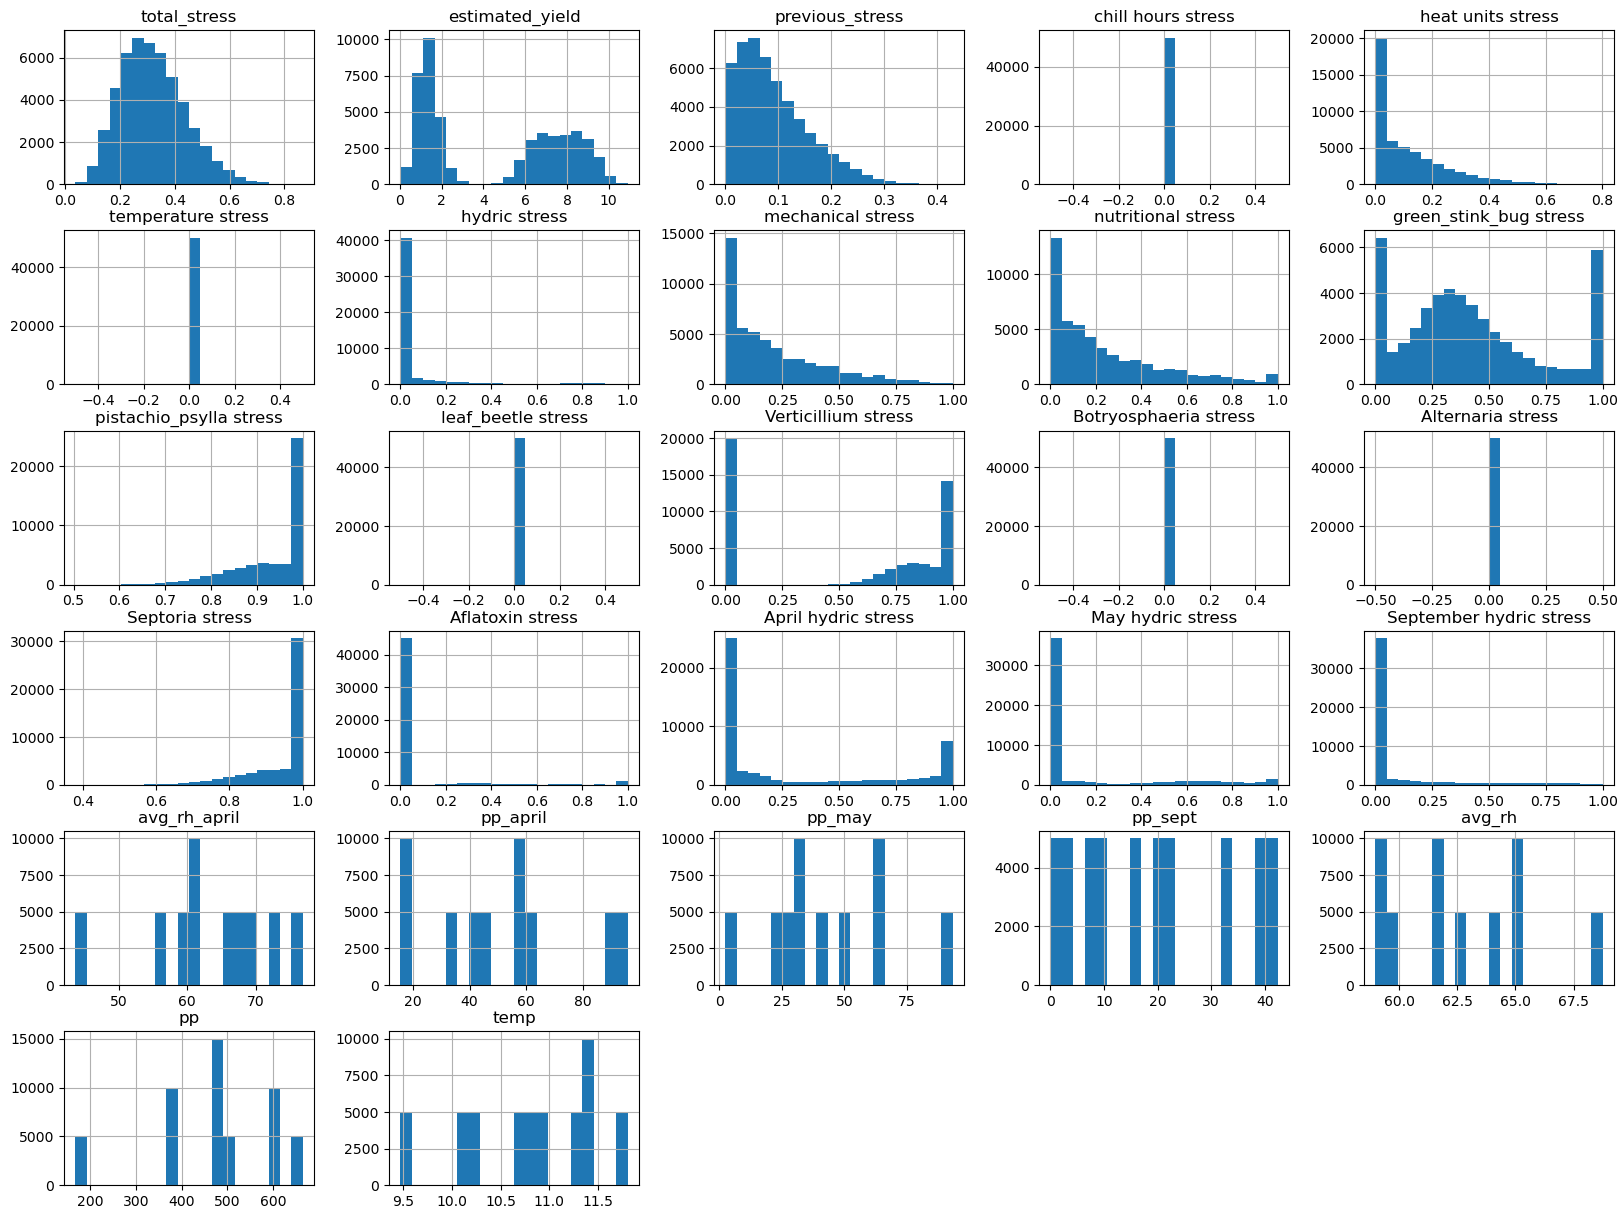

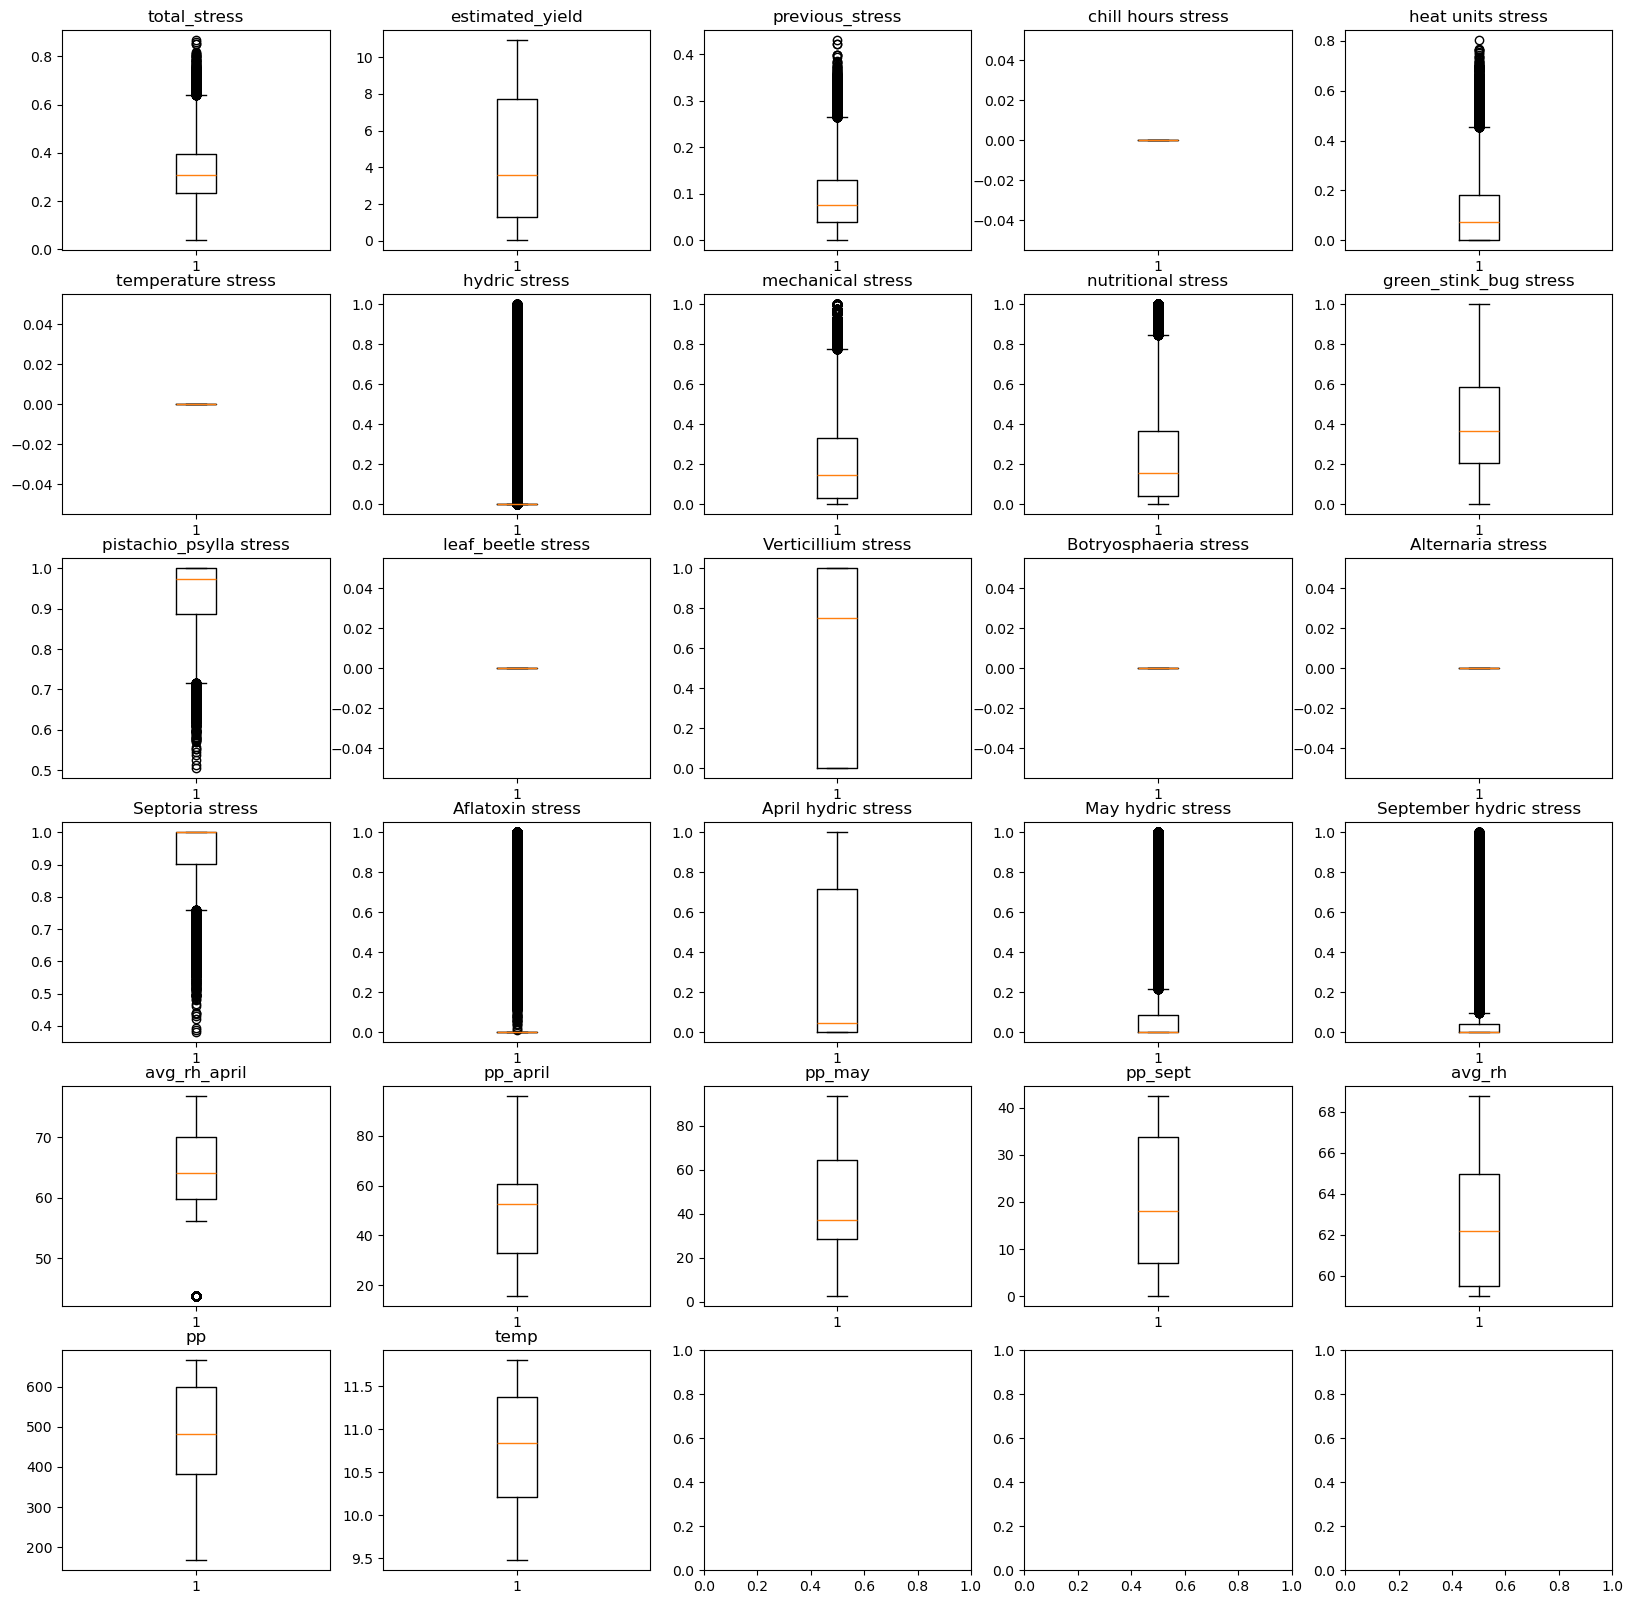

In [20]:
# Distribution of the estimated yield, total stress, previous stress, and stressors
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

numeric_df.hist(bins=20, figsize=(20,15))
plt.show()

# Boxplot of the estimated yield, total stress, previous stress, and stressors
# Do a 6x6 grid of boxplots
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, col in enumerate(numeric_df.columns):
    axs[i//5, i%5].boxplot(numeric_df[col])
    axs[i//5, i%5].set_title(col)

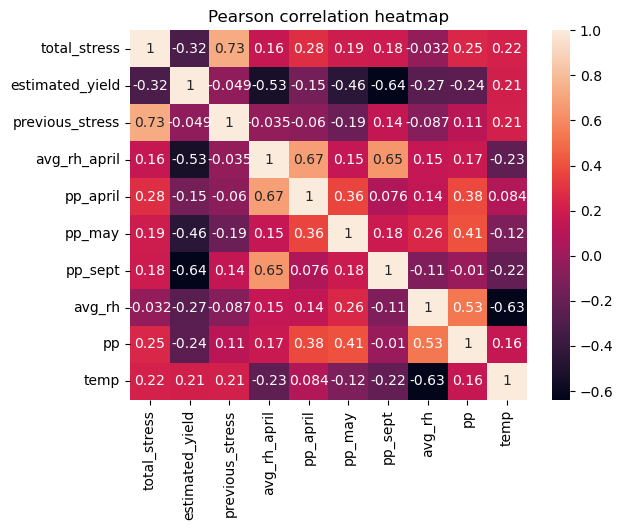

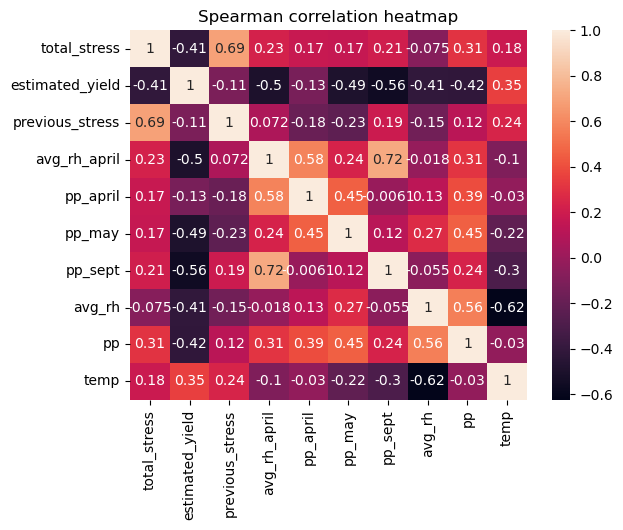

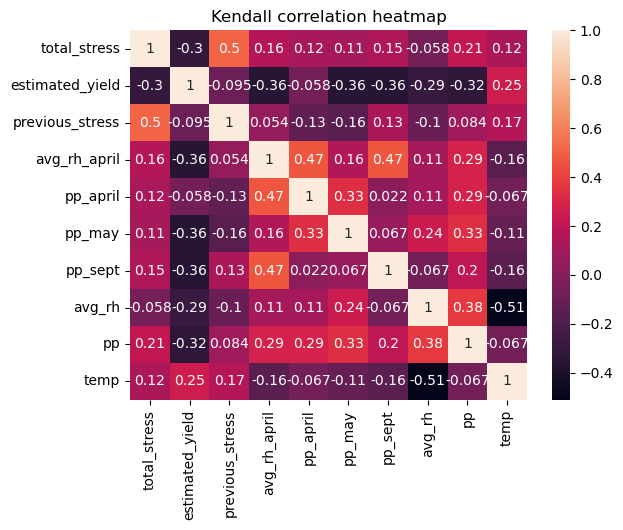

In [21]:
# Heatmap of the correlation between the variables
import seaborn as sns
sns.heatmap(df[["total_stress", "estimated_yield", "previous_stress", "avg_rh_april", "pp_april", "pp_may", "pp_sept", "avg_rh", "pp", "temp"]].corr(method='pearson'), annot=True)
plt.title("Pearson correlation heatmap")
plt.show()
sns.heatmap(df[["total_stress", "estimated_yield", "previous_stress", "avg_rh_april", "pp_april", "pp_may", "pp_sept", "avg_rh", "pp", "temp"]].corr(method='spearman'), annot=True)
plt.title("Spearman correlation heatmap")
plt.show()
sns.heatmap(df[["total_stress", "estimated_yield", "previous_stress", "avg_rh_april", "pp_april", "pp_may", "pp_sept", "avg_rh", "pp", "temp"]].corr(method='kendall'), annot=True)
plt.title("Kendall correlation heatmap")
plt.show()

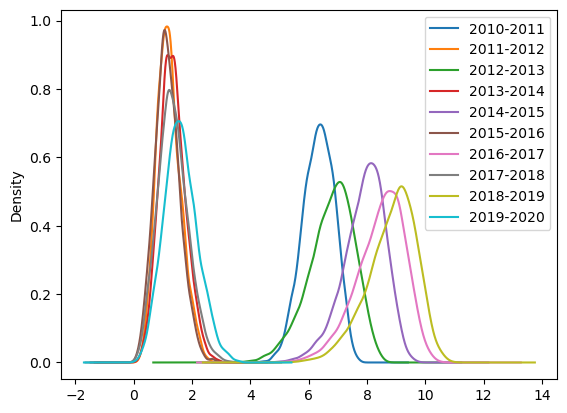

,total_stress,estimated_yield,previous_stress,chill hours stress,heat units stress,temperature stress,hydric stress,mechanical stress,nutritional stress,green_stink_bug stress,...,May hydric stress,September hydric stress,avg_rh_april,pp_april,pp_may,pp_sept,avg_rh,pp,temp,is_on_year
year,,,,,,,,,,,,,,,,,,,,,
2010-2011,0.207747,6.337978,0.000000,0.0,0.099353,0.0,0.000000,0.211805,0.209039,0.458749,...,0.344414,0.000000,59.833333,60.8,64.6,0.0,62.452514,467.2,10.766760,1.0
2011-2012,0.302872,1.215132,0.062259,0.0,0.147683,0.0,0.454184,0.211805,0.409122,0.505582,...,0.000000,0.434811,71.954545,46.2,49.2,42.4,59.490566,167.6,10.169182,0.0
2012-2013,0.277091,6.783226,0.093531,0.0,0.234836,0.0,0.000000,0.211805,0.209039,0.435569,...,0.000000,0.000000,66.400000,59.2,41.8,15.0,68.751497,505.6,9.473952,1.0
2013-2014,0.290926,1.334836,0.087849,0.0,0.174845,0.0,0.000000,0.211805,0.209039,0.603057,...,0.000000,0.000000,61.720000,32.8,23.4,23.0,65.075988,490.0,10.213374,0.0
2014-2015,0.261693,7.906417,0.092288,0.0,0.040603,0.0,0.000000,0.211805,0.209039,0.000000,...,0.000000,0.000000,56.173913,15.8,2.4,7.0,61.913738,383.2,10.915016,1.0
2015-2016,0.428495,1.161689,0.083869,0.0,0.127411,0.0,0.033737,0.211805,0.223955,0.673767,...,0.347629,0.000000,70.100000,95.8,64.8,10.0,64.936639,601.2,11.323140,0.0
2016-2017,0.316933,8.464490,0.133509,0.0,0.035187,0.0,0.000000,0.211805,0.209039,0.208386,...,0.000000,0.000000,43.733333,15.6,30.8,3.6,59.372222,373.8,11.802222,1.0
2017-2018,0.396577,1.345568,0.102248,0.0,0.089066,0.0,0.166752,0.211805,0.282909,0.507117,...,0.798606,0.187283,60.592593,42.4,93.4,33.8,64.284900,665.4,10.650142,0.0
2018-2019,0.393687,8.850461,0.125309,0.0,0.112839,0.0,0.000000,0.211805,0.209039,0.380221,...,0.000000,0.000000,68.200000,89.2,28.5,21.2,58.988827,472.8,11.374302,1.0


In [22]:
# Plot distribution grouped by year
import matplotlib.pyplot as plt
df.groupby("year").estimated_yield.plot(kind="kde", legend=True)
plt.show()

# Group by year and get the mean and add count column
# df_grouped = df.groupby("year").agg(
#     total_stress_mean=("total_stress", "mean"),
#     estimated_yield_mean=("estimated_yield", "mean"),
#     previous_stress_mean=("previous_stress", "mean"),
#     count=("estimated_yield", "count")
# )
df_grouped = df.groupby("year").mean()
display(df_grouped)


## Feed an AI model with the data

Now that we have the best model possible for the real data, we can feed an AI model with the data to predict the yield of the pistachio crop in the future. We are going to test different models and compare the results. 

In [24]:
test_size = 0.2

# Split the data into train and test
data = df_grouped.copy()
# Put estimated_yield at the end
data = data[[c for c in data if c not in ["estimated_yield"]] + ["estimated_yield"]]

In [25]:
# Functions
def metrics_and_plots(y_true, y_pred, X_test, only_metrics=False):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.metrics import mean_squared_error, r2_score
    import seaborn as sns
    # Metrics
    from sklearn.metrics import mean_squared_error, r2_score
    import statistics as stat
    # Remove hours 1-7
    y_true_df = pd.DataFrame(y_true)
    y_pred_df = pd.DataFrame(y_pred)
    # Rename 
    y_pred_df.columns = ['liters']
    y_true_df.columns = ['liters']
    print('R2:', r2_score(y_true_df["liters"], y_pred_df["liters"]))
    print('RMSE:', mean_squared_error(y_true_df["liters"], y_pred_df["liters"], squared=False))
    print('Max error:', max(abs(y_true_df["liters"] - y_pred_df["liters"])))
    print('Error median:', np.median(abs(y_true_df["liters"] - y_pred_df["liters"])))
    print('Error std:', np.std(abs(y_true_df["liters"] - y_pred_df["liters"])))
    # Accuracy (inside 10%/25% error)
    print('Accuracy (<10%):', len(y_true_df[(abs(y_true_df["liters"] - y_pred_df["liters"]) / y_true_df["liters"]) < 0.1]) / len(y_true_df))
    print('Accuracy (<25%):', len(y_true_df[(abs(y_true_df["liters"] - y_pred_df["liters"]) / y_true_df["liters"]) < 0.25]) / len(y_true_df))

    if only_metrics:
        return
    # Plot error by day of the week
    error = abs(y_true.ravel() - y_pred.ravel())
    error = pd.DataFrame(error)
    # Group by day of the week
    error['dayOfWeek'] = X_test[:, 5]
    error['hour'] = X_test[:, -1]
    # Filter by hours distinct to 1-7
    error = error[~error['hour'].isin([1, 2, 3, 4, 5, 6, 7])]
    # Group by hour
    error_mean = error.drop(columns=['dayOfWeek']).groupby('hour').mean()
    error_var = error.drop(columns=['dayOfWeek']).groupby('hour').std()
    # Plot all errors
    fig, axs = plt.subplots(1, 2, figsize=(23, 4))
    error_mean.plot(kind='bar', title='Error medio por hora - Horas distintas a 1-7', ax=axs[0])
    error_var.plot(kind='bar', title='Error varianza por hora - Horas distintas a 1-7', ax=axs[1])
    # Group by day of the week
    error = error.drop(columns=['hour'])
    error_mean = error.groupby('dayOfWeek').mean()
    error_var = error.groupby('dayOfWeek').std()
    # Plot all errors
    fig, axs = plt.subplots(1, 2, figsize=(23, 4))
    error_mean.plot(kind='bar', title='Error medio por día de la semana - Horas distintas a 1-7', ax=axs[0])
    error_var.plot(kind='bar', title='Error varianza por día de la semana - Horas distintas a 1-7', ax=axs[1])
    # Plot number of errors by group of errors
    plt.figure()
    error['group'] = pd.cut(error[0], bins=[0, 5, 10, 15, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000], right=False)
    error_group = error.groupby('group').size()
    error_group.plot(kind='bar', title='Número de errores por grupo de error - Horas distintas a 1-7', figsize=(18, 5))
    # New variable weekend and weekday
    y_true_df['Weekend'] = y_true_df['dayOfWeek'].apply(lambda x: "Fin de semana" if x in [5, 6] else "Entre semana")
    # Plot real vs predicted hue weekend
    plt.figure()
    sns.scatterplot(data=y_true_df, x='liters', y=y_pred_df['liters'], hue='Weekend')
    plt.title('Real vs Predicted - day of the week')
    plt.xlabel('Real')
    plt.ylabel('Predicted')
    plt.legend()
    plt.show()

def plot_residuals(y_test, y_pred):
    # Residuals qqplot
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    # Calculate residuals
    residuals = y_test.ravel() - y_pred
    # QQ plot
    fig, axes = plt.subplots(1, 2, figsize=(25, 6), gridspec_kw={'width_ratios': [2, 3]})
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=axes[0])
    axes[0].set_title('QQ plot')
    axes[1].set_title('residuals')
    axes[1].plot(residuals)

### XGBoost

/Users/topopelon/miniconda3/envs/pistachio-simulation/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


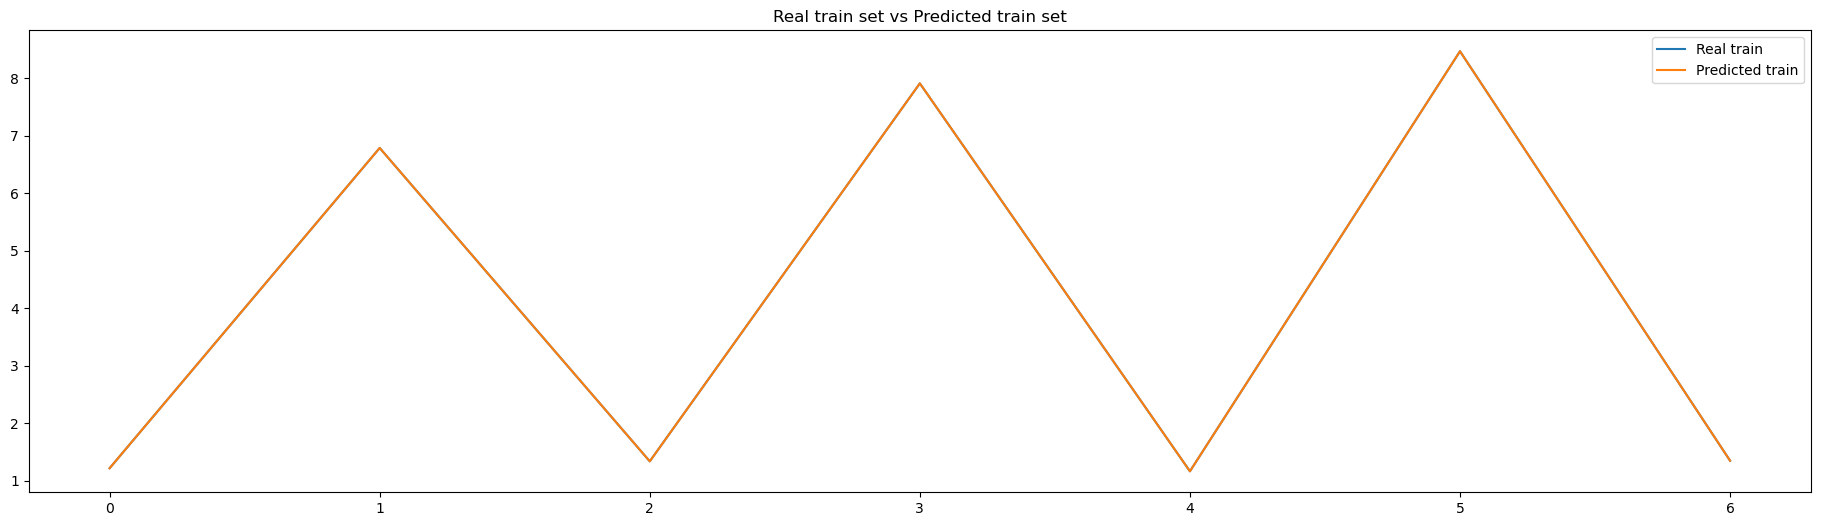

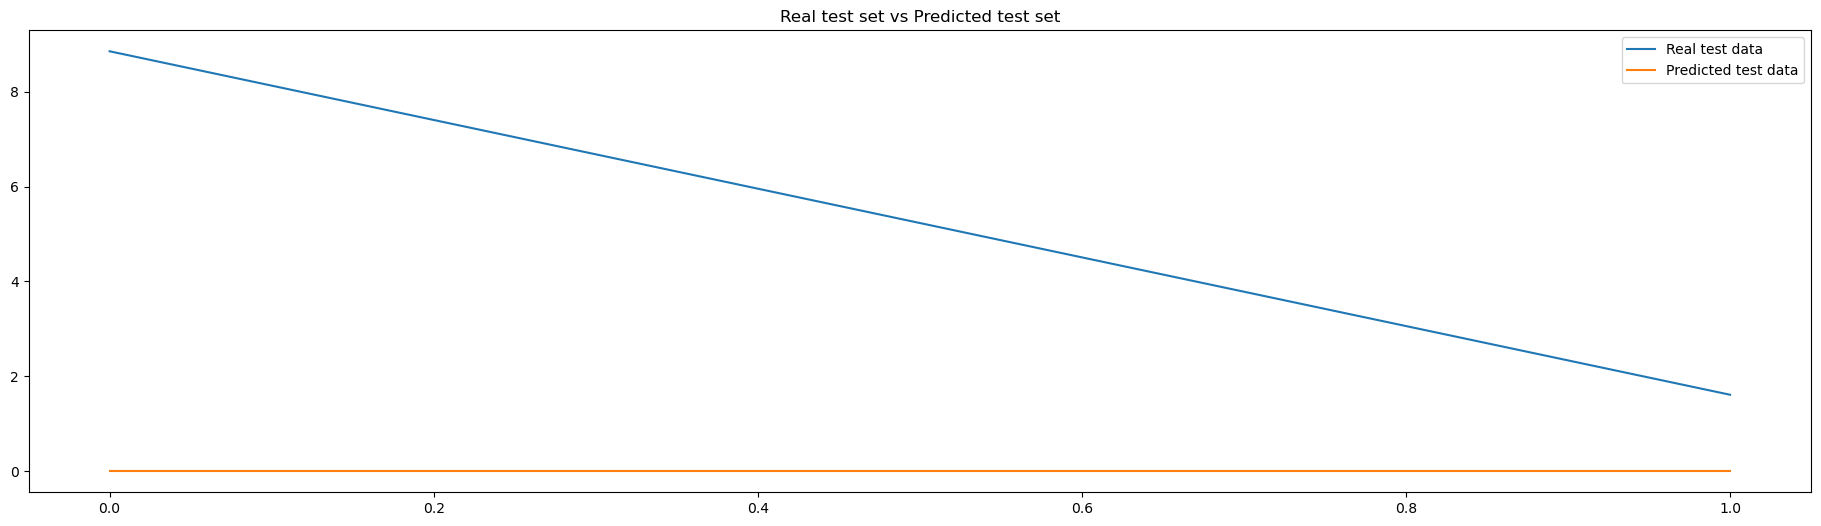

R2: -2.08977937229751
RMSE: 6.3612571801460875
Max error: 8.850460624549923
Error median: 5.231538652367589
Error std: 3.618921972182334
Accuracy (<10%): 0.0
Accuracy (<25%): 0.0


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import xgboost
# Bayesian Ridge
from sklearn.linear_model import BayesianRidge

# Scale
# scaler = StandardScaler()
# Drop NaN
data = data.dropna()
# Split data
def split_sequence(sequence, n_steps_in, n_steps_out):
    '''
    Split data into sequences of length n_steps_in. This is the sliding window approach
    where we use the last n_steps_in values to predict the next n_steps_out. In this case,
    we only need to predict the next value. You can uncommnet the `print(f'{seq_x} => {seq_y}')`
    statement to see the windows created and the corresponding output.
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix+n_steps_out-1:out_end_ix, -1]
        # seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
        # print(f'{seq_x} => {seq_y}')
    return np.array(X), np.array(y)

X, y = split_sequence(data.values, 1, 1)
X = X.reshape((X.shape[0], -1))
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
# Scale
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# Best params in optuna
# params = {
#     'n_estimators': 5000,
#     'max_depth': 7,
#     'learning_rate': 0.0008313896119288818,
#     'gamma': 0.007851369783179437,
#     'subsample': 0.8180179222776849,
#     'colsample_bytree': 0.6021960309532763,
#     'random_state': 123,
#     'enable_categorical': True,
# }
model = BayesianRidge()
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
# y_pred < 100 = 0.
y_pred[y_pred < 100] = 0
# Plot real vs predicted
plt.figure(figsize=(23, 6))
plt.title('Real train set vs Predicted train set')
plt.plot(y_train.ravel(), label='Real train')
plt.plot(y_pred_train.ravel(), label='Predicted train')
plt.legend()
plt.show()

plt.figure(figsize=(23, 6))
plt.title("Real test set vs Predicted test set")
plt.plot(y_test.ravel(), label='Real test data')
plt.plot(y_pred.ravel(), label='Predicted test data')
plt.legend()
plt.show()
# Metrics
metrics_and_plots(y_test.ravel(), y_pred.ravel(), np.array(X_test), only_metrics=True)
# Residuals
# plot_residuals(y_test, y_pred)